In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import copy
import os

# from IPython.display import HTML
# from IPython import display
# from IPython.display import clear_output

# from gym.wrappers.record_video import RecordVideo
from minigrid.wrappers import *

from minigrid.wrappers import FullyObsWrapper, ImgObsWrapper, NoDeath
from minigrid.core.actions import Actions
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from minigrid_custom_train import UpgradedObjEnvExtractor


# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Flatten
# from tensorflow.keras.optimizers import Adam

from minigrid_custom_env import *
from minigrid_custom_train import *
from dpu_clf import *


plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%reload_ext autoreload

%load_ext autoreload
%autoreload 2




def create_env_from_model(model_name, grid_size, agent_view_size, max_steps, highlight, num_objects, lava_cells, train_env=True, image_full_view=False, image_obs=False):
    env_info = model_name.split('S')[0].split(',')
    lava_cost = float(env_info[3])
    step_cost = float(env_info[4])
    colors_rewards = {'red':float(env_info[0]), 'green': float(env_info[1]), 'blue': float(env_info[2])}
    step_count = True if 'Step_Count' in model_name else False
    base_env =  CustomEnv(
            grid_size=grid_size,
            render_mode='rgb_array',
            max_steps=max_steps,
            highlight=highlight,
            step_cost=step_cost,
            num_objects=num_objects,
            lava_cells=lava_cells,
            train_env=train_env,
            image_full_view=image_full_view,
            agent_view_size=agent_view_size,
            color_rewards=colors_rewards,
            step_count_observation=step_count,
            # small_actions_space=True, 
        )
    if image_obs:
        print("Using image observations")
        base_env = NoDeath(ObjObsWrapperImageOnly(base_env), no_death_types=('lava',), death_cost=lava_cost)
    else:
        base_env = NoDeath(ObjObsWrapper(base_env), no_death_types=('lava',), death_cost=lava_cost)
    return base_env

def create_basic_env(train_env=False, image_full_view=False):
    lava_cost = -3
    step_cost = 0.1
    colors_rewards = {'red':-0.1, 'green': 2, 'blue': 4}
    step_count = False
    base_env =  CustomEnv(
            grid_size=8,
            render_mode='rgb_array',
            max_steps=50,
            highlight=True,
            step_cost=step_cost,
            num_objects=4,
            lava_cells=4,
            train_env=train_env,
            image_full_view=image_full_view,
            agent_view_size=7,
            color_rewards=colors_rewards,
            step_count_observation=step_count,
            # small_actions_space=True, 
        )
    base_env = NoDeath(ObjObsWrapper(base_env), no_death_types=('lava',), death_cost=lava_cost)
    return base_env

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-7
<class 'numpy.ndarray'> (256, 256, 3)


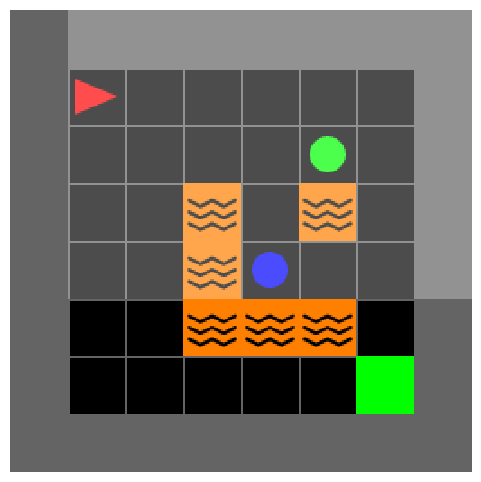

In [33]:
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import imageio
import base64
from io import BytesIO
import numpy as np
import time
import copy

#test the environment

def plot_state(env):
    img = env.get_full_image()
    print(type(img), img.shape)

    plt.imshow(img)
    plt.axis("off")
    plt.show()

def save_env_state_to_image(env, filename="env_state.png"):
    """Save the current environment state as an image in the 'images' directory."""
    # Ensure the directory exists
    os.makedirs("images", exist_ok=True)
    
    # Render the environment and save the image
    img = env.render()
    image_path = os.path.join("images", filename)
    Image.fromarray(img).save(image_path)
    print(f"Environment state saved to {image_path}")

    
# env = CustomEnv(size = 8, render_mode='rgb_array', difficult_grid=False, agent_pov=True, step_count_observation=False)
# env = ImgObsWrapper(ObjObsWrapper(env))
grid_size = 8
max_steps = 300
agent_view_size = 7
lava_cost = -5
unique_env = 7
colors_rewards = {'red':3, 'green': 1, 'blue': 0}
kwargs = {
    # "initial_balls": initial_balls,
    # "other_lava_cells": other_lava_cells,
    "grid_size": grid_size,
    "render_mode": 'rgb_array',
    "max_steps": max_steps,
    "highlight": True,
    "step_count_observation": False,
    "num_objects": 4,
    "train_env": False,
    "image_full_view": False,
    "agent_view_size": agent_view_size,
    "colors_rewards": colors_rewards,
    "num_lava_cells": 5,
    "unique_env": unique_env,
    
}

env = CustomEnv(**kwargs)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=lava_cost)
initial_k = {'unique_env': unique_env}
current_obs, _ = env.unwrapped.reset(**initial_k)
# env = ObjObsWrapper(env)


# current_obs = env.reset()
# current_obs = current_obs[0]
plot_state(env)



In [3]:
initial_balls = env.get_wrapper_attr('initial_balls')
other_lava_cells = env.get_wrapper_attr('lava_cells')
print(other_lava_cells)
print(initial_balls)


[(5, 3), (3, 5), (2, 1), (5, 3), (1, 6), (5, 2), (2, 4)]
[(6, 2, 'green', 2), (2, 3, 'green', 2), (6, 1, 'red', 0.1), (5, 3, 'blue', 4), (2, 2, 'green', 2), (6, 5, 'blue', 4), (2, 5, 'green', 2), (6, 2, 'red', 0.1)]


In [6]:
# models distnces - models neighbours
import numpy as np
new_models_dict = {
    1: {"path": "models/3,3,3,0.1,0.1Steps100Grid8_20250602/best_model.zip", "name": "AllColorsLL1_0526", "vector": (3, 3, 3, 0.1, 0.1)},
    2: {"path": "models/3,3,4,0.2,0.05Steps50Grid8_20250604/best_model.zip", "name": "AllColorsLL2_0604", "vector": (3, 3, 4, 0.2, 0.05)},
    3: {"path": "models/2,2,4,-4,0.1Steps50Grid8_20250617/best_model.zip", "name": "AllColorsLH_0611", "vector": (2, 2, 4, -3, 0.1)},
    4: {"path": "models/2,2,4,-3,0.1Steps50Grid8_20250611/best_model.zip", "name": "AllColorsLH_0411", "vector": (2,2,4,-3,0.1)},
    5: {"path": "models/-0.5,2,4,-3,0.1Steps50Grid8_20250612_good/best_model.zip", "name": "NoRedLH1_0612", "vector": (-0.5,2,4,-3,0.1)},
    6: {"path": "models/-0.5,3,4,0.2,0.1Steps50Grid8_20250616/best_model.zip", "name": "NoRedLL_0616", "vector": (-0.5, 3, 4, 0.2, 0.1)},
    7: {"path": "models/-1,4,-1,0.2,0.1Steps60Grid8_20250618/best_model", "name": "OnlyGreenLL_0429", "vector": (-0.1, 3, -0.1, 0, 0.01)},
    8: {"path": "models/-1,3,4,-3,0.1Steps60Grid8_20250618/best_model.zip", "name": "NoRedLH2_0618", "vector": (-1, 3, 4, -3, 0.1)},
    9: {"path": "models/-0.5,3,4,-3,0.1Steps50Grid8_20250616/best_model.zip", "name": "NoRedLH3_0612", "vector": (-0.5, 3, 4, -3, 0.1)},
    10:{"path": "models/-1,3,4,0.2,0.2Steps50Grid8_20250617/best_model.zip", "name": "NoRedLL_G_0617", "vector": (-1, 3, 4, 0.2, 0.2)},
}

normelize_models_dict = copy.deepcopy(new_models_dict)
def euclidean(vector1, vector2):
    return np.sqrt(np.sum((np.array(vector1) - np.array(vector2)) ** 2))


# Calculate distances between models and find the 5 closest models for each
new_models_distance = {}
for i, (model_id_i, model_data_i) in enumerate(normelize_models_dict.items()):
    vector_i = model_data_i["vector"]
    distances = []
    for j, (model_id_j, model_data_j) in enumerate(normelize_models_dict.items()):
        if i != j:
            vector_j = model_data_j["vector"]
            # Normalize each vector by itself so its max is 1 and min is 0
            def normalize(vec):
                vec = np.array(vec, dtype=np.float32)
                min_v = vec.min()
                max_v = vec.max()
                if max_v - min_v < 1e-8:
                    return np.zeros_like(vec)
                return (vec - min_v) / (max_v - min_v)
            norm_vector_i = normalize(vector_i)
            norm_vector_j = normalize(vector_j)
            dist = euclidean(norm_vector_i, norm_vector_j)
            distances.append((model_id_j, dist))
    # Sort by distance and take the 5 closest models
    closest_models = sorted(distances, key=lambda x: x[1])[:4]
    new_models_distance[model_id_i] = [(model_id, normelize_models_dict[model_id]["name"]) for model_id, _ in closest_models]


new_models_distance



{1: [(2, 'AllColorsLL2_0604'),
  (3, 'AllColorsLH_0611'),
  (4, 'AllColorsLH_0411'),
  (9, 'NoRedLH3_0612')],
 2: [(1, 'AllColorsLL1_0526'),
  (3, 'AllColorsLH_0611'),
  (4, 'AllColorsLH_0411'),
  (5, 'NoRedLH1_0612')],
 3: [(4, 'AllColorsLH_0411'),
  (5, 'NoRedLH1_0612'),
  (9, 'NoRedLH3_0612'),
  (2, 'AllColorsLL2_0604')],
 4: [(3, 'AllColorsLH_0611'),
  (5, 'NoRedLH1_0612'),
  (9, 'NoRedLH3_0612'),
  (2, 'AllColorsLL2_0604')],
 5: [(9, 'NoRedLH3_0612'),
  (8, 'NoRedLH2_0618'),
  (3, 'AllColorsLH_0611'),
  (4, 'AllColorsLH_0411')],
 6: [(10, 'NoRedLL_G_0617'),
  (8, 'NoRedLH2_0618'),
  (5, 'NoRedLH1_0612'),
  (9, 'NoRedLH3_0612')],
 7: [(6, 'NoRedLL_0616'),
  (10, 'NoRedLL_G_0617'),
  (8, 'NoRedLH2_0618'),
  (9, 'NoRedLH3_0612')],
 8: [(9, 'NoRedLH3_0612'),
  (5, 'NoRedLH1_0612'),
  (10, 'NoRedLL_G_0617'),
  (3, 'AllColorsLH_0611')],
 9: [(8, 'NoRedLH2_0618'),
  (5, 'NoRedLH1_0612'),
  (3, 'AllColorsLH_0611'),
  (4, 'AllColorsLH_0411')],
 10: [(6, 'NoRedLL_0616'),
  (8, 'NoRedLH2_061

In [5]:
for k, v in new_models_distance.items():
    print(f"{k}:")
    for neighbor in v:
        print(f"{neighbor}", end=',')
    print()

1:
(2, 'AllColorsLL2_0604'),(3, 'AllColorsLH_0611'),(4, 'AllColorsLH_0411'),(9, 'NoRedLH3_0612'),
2:
(1, 'AllColorsLL1_0526'),(3, 'AllColorsLH_0611'),(4, 'AllColorsLH_0411'),(5, 'NoRedLH1_0612'),
3:
(4, 'AllColorsLH_0411'),(5, 'NoRedLH1_0612'),(9, 'NoRedLH3_0612'),(2, 'AllColorsLL2_0604'),
4:
(3, 'AllColorsLH_0611'),(5, 'NoRedLH1_0612'),(9, 'NoRedLH3_0612'),(2, 'AllColorsLL2_0604'),
5:
(9, 'NoRedLH3_0612'),(8, 'NoRedLH2_0618'),(3, 'AllColorsLH_0611'),(4, 'AllColorsLH_0411'),
6:
(10, 'NoRedLL_G_0617'),(8, 'NoRedLH2_0618'),(5, 'NoRedLH1_0612'),(9, 'NoRedLH3_0612'),
7:
(6, 'NoRedLL_0616'),(10, 'NoRedLL_G_0617'),(8, 'NoRedLH2_0618'),(9, 'NoRedLH3_0612'),
8:
(9, 'NoRedLH3_0612'),(5, 'NoRedLH1_0612'),(10, 'NoRedLL_G_0617'),(3, 'AllColorsLH_0611'),
9:
(8, 'NoRedLH2_0618'),(5, 'NoRedLH1_0612'),(3, 'AllColorsLH_0611'),(4, 'AllColorsLH_0411'),
10:
(6, 'NoRedLL_0616'),(8, 'NoRedLH2_0618'),(9, 'NoRedLH3_0612'),(5, 'NoRedLH1_0612'),


In [6]:

model_name = '-0.5,3,3,0,0.01Steps100Grid8_20250605' #'1,1,1,-1,0.01Steps200Grid8_20250409'
grid_size = 8
max_steps = 100
agent_view_size = 7
num_balls = 4
num_lava_cell = 4
env = create_env_from_model(
        model_name=model_name,
        grid_size=grid_size,
        agent_view_size=agent_view_size,
        max_steps=max_steps,
        highlight=True,
        num_objects=num_balls,
        lava_cells=num_lava_cell,
        train_env=True,
        image_full_view=False,
        )
# env = VecNormalize(env, norm_obs=True, norm_reward=False, clip_obs=10.0)
# env_instance = CustomEnv(
#         grid_szie=8, render_mode="rgb_array", image_full_view=False,
#         highlight=True, max_steps=100, num_objects=5, lava_cells=3, partial_obs=True,
#         unique_env=0
#     )
# env = NoDeath(ObjObsWrapper(env_instance), no_death_types=("lava",), death_cost=-3)
model_path = os.path.join("models", model_name, "best_model")
agent = load_agent(env, model_path, update=False)
eval_res = evaluate_agent(env, agent, 100)
print(eval_res)

load new model path models\-0.5,3,3,0,0.01Steps100Grid8_20250605\best_model


FileNotFoundError: [Errno 2] No such file or directory: 'models\\-0.5,3,3,0,0.01Steps100Grid8_20250605\\best_model.zip'

In [ ]:
import os

# Initialize the new dictionary
new_models_dict = {}

# Iterate through the files in the 'models' directory
for idx, model_dir in enumerate(os.listdir("models"), start=1):
    model_path = os.path.join("models", model_dir, "best_model.zip")
    if os.path.isdir(os.path.join("models", model_dir)) and os.path.exists(model_path):
        # Extract the vector from the directory name (assuming it's part of the name)
        vector = tuple(map(float, model_dir.split("Steps")[0].split("_")[0].split(",")))
        new_models_dict[idx] = {
            "path": model_dir,
            "name": "",
            "vector": vector
        }

# Print the resulting dictionary
new_models_names = [x['path'] for x in list(new_models_dict.values())]
print(len(new_models_dict), new_models_names)

20 ['-0.1,3,-0.1,0,0.01Steps100Grid8_20250429', '-0.5,-0.5,4,-3,0.1Steps50Grid8_20250612', '-0.5,2,4,-2,0.1Steps50Grid8_20250612', '-0.5,2,4,-3,0.1Steps50Grid8_20250612_good', '-0.5,3,4,-3,0.1Steps50Grid8_20250616', '-0.5,3,4,-3,0.1Steps60Grid8_20250617', '-0.5,3,4,0.2,0.1Steps50Grid8_20250616', '-1,-1,4,0.2,0.1Steps60Grid8_20250618', '-1,3,4,-3,0.1Steps60Grid8_20250618', '-1,3,4,0.2,0.2Steps50Grid8_20250617', '-1,4,-1,0.2,0.1Steps60Grid8_20250618', '2,-0.5,4,0.2,0.1Steps50Grid8_20250615', '2,-0.5,4,0.2,0.1Steps50Grid8_20250616', '2,2,2,-4,0.02Steps100Grid8_20250422', '2,2,2,0,0.1Steps100Grid8_20250526', '2,2,4,-3,0.1Steps50Grid8_20250611', '2,2,4,-4,0.1Steps50Grid8_20250617', '2,2,4,0.2,0.1Steps100Grid8_20250612', '3,3,3,0.1,0.1Steps100Grid8_20250602', '3,3,4,0.2,0.05Steps50Grid8_20250604']


In [ ]:
new_models_dict = {
    1: {"path": "models/3,3,3,0.1,0.1Steps100Grid8_20250602/best_model.zip", "name": "AllColorsLL1_0526", "vector": (3, 3, 3, 0.1, 0.1)},
    2: {"path": "models/3,3,4,0.2,0.05Steps50Grid8_20250604/best_model.zip", "name": "AllColorsLL2_0604", "vector": (3, 3, 4, 0.2, 0.05)},
    3: {"path": "models/2,2,4,-4,0.1Steps50Grid8_20250617/best_model.zip", "name": "AllColorsLH_0617", "vector": (2, 2, 4, -3, 0.1)},
    4: {"path": "models/-1,-1,4,0.2,0.1Steps70Grid8_20250625/best_model.zip", "name": "OnlyBlueLL_0625", "vector": (-1,-1,4,0.2,0.1)}, 
    5: {"path": "models/-0.5,2,4,-3,0.1Steps50Grid8_20250612_good/best_model.zip", "name": "NoRedLH1_0612", "vector": (-0.5,2,4,-3,0.1)},
    6: {"path": "models/-0.5,3,4,0.2,0.1Steps50Grid8_20250616/best_model.zip", "name": "NoRedLL_0616", "vector": (-0.5, 3, 4, 0.2, 0.1)},
    7: {"path": "models/-1,4,-1,0.2,0.1Steps60Grid8_20250618/best_model", "name": "OnlyGreenLL_0429", "vector": (-0.1, 3, -0.1, 0, 0.01)},
    8: {"path": "models/-1,3,4,-3,0.1Steps60Grid8_20250618/best_model.zip", "name": "NoRedLH2_0618", "vector": (-1, 3, 4, -3, 0.1)},
    9: {"path": "models/-0.5,3,4,-3,0.1Steps50Grid8_20250616/best_model.zip", "name": "NoRedLH3_0612", "vector": (-0.5, 3, 4, -3, 0.1)},
    10:{"path": "models/-1,3,4,0.2,0.2Steps50Grid8_20250617/best_model.zip", "name": "NoRedLL_G_0617", "vector": (-1, 3, 4, 0.2, 0.2)},
}

new_models_names = [x['path'].split('/')[1] for x in list(new_models_dict.values())]
new_models_names

['3,3,3,0.1,0.1Steps100Grid8_20250602',
 '3,3,4,0.2,0.05Steps50Grid8_20250604',
 '2,2,4,-4,0.1Steps50Grid8_20250617',
 '-1,-1,4,0.2,0.1Steps70Grid8_20250625',
 '-0.5,2,4,-3,0.1Steps50Grid8_20250612_good',
 '-0.5,3,4,0.2,0.1Steps50Grid8_20250616',
 '-1,4,-1,0.2,0.1Steps60Grid8_20250618',
 '-1,3,4,-3,0.1Steps60Grid8_20250618',
 '-0.5,3,4,-3,0.1Steps50Grid8_20250616',
 '-1,3,4,0.2,0.2Steps50Grid8_20250617']

In [ ]:
models_evaluations = []
grid_size = 8
max_steps = 50
agent_view_size = 7
num_balls = 5
num_lava_cell = 4

env_name = "-1,3,4,-3,0.1Steps60Grid8_20250618"

for model_name in new_models_names:
    env = create_env_from_model(
        model_name=env_name,
        grid_size=grid_size,
        agent_view_size=agent_view_size,
        max_steps=max_steps,
        highlight=True,
        num_objects=num_balls,
        lava_cells=num_lava_cell,
        train_env=False,
        image_full_view=False,
        )    
    model_path = os.path.join("models", model_name, "best_model")
    try:
        agent = load_agent(env, model_path)
    except Exception as e:
        print(f"--------------- fail to load agent for model {model_name}: {e}")
        continue
    eval_res = evaluate_agent(env, agent, num_episodes=100, from_unique_env=True)
    models_evaluations.append({"model name": model_name, "model mean score": eval_res[0], "model mean illegal moves": eval_res[1], "model mean steps": eval_res[2], 
                               "reached_max_steps": eval_res[3]})

-1,3,4,-3,0.1Steps60Grid8_20250618
['-1,3,4,-3,0.1', 'teps60Grid8_20250618']
['-1', '3', '4', '-3', '0.1']
load new model path models\3,3,3,0.1,0.1Steps100Grid8_20250602\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0804 seconds.
generate unique env number-12
generate unique env number-7
generate unique env number-8
generate unique env number-5
generate unique env number-2
generate unique env number-1
generate unique env number-3
generate unique env number-4
generate unique env number-11
generate unique env number-10
generate unique env number-6
generate unique env number-10
generate unique env number-10
generate unique env number-10
generate unique env number-4
generate unique env number-9
generate unique env number-10
generate unique env number-12
generate unique env number-11
generate unique env number-4
generate unique env number-11
generate unique env number-7
generate u

In [ ]:
for model_eval in models_evaluations:
    print(model_eval)

{'model name': '3,3,3,0.1,0.1Steps100Grid8_20250602', 'model mean score': -3.584860000000017, 'model mean illegal moves': 0, 'model mean steps': 18, 'reached_max_steps': 0}
{'model name': '3,3,4,0.2,0.05Steps50Grid8_20250604', 'model mean score': -16.003919999999667, 'model mean illegal moves': 0, 'model mean steps': 23, 'reached_max_steps': 13}
{'model name': '2,2,4,-4,0.1Steps50Grid8_20250617', 'model mean score': 3.3411399999999576, 'model mean illegal moves': 0, 'model mean steps': 25, 'reached_max_steps': 0}
{'model name': '-1,-1,4,0.2,0.1Steps70Grid8_20250625', 'model mean score': -3.6720200000000305, 'model mean illegal moves': 0, 'model mean steps': 14, 'reached_max_steps': 0}
{'model name': '-0.5,2,4,-3,0.1Steps50Grid8_20250612_good', 'model mean score': 4.5956399999999, 'model mean illegal moves': 0, 'model mean steps': 21, 'reached_max_steps': 8}
{'model name': '-0.5,3,4,0.2,0.1Steps50Grid8_20250616', 'model mean score': 0.7418600000000011, 'model mean illegal moves': 0, 'mo

In [ ]:
models_part_eval = []
for model_eval in models_evaluations:
    models_part_eval.append({model_eval["model name"] : model_eval['model mean score']})
print(models_part_eval)

[{'3,3,3,0.1,0.1Steps100Grid8_20250602': -3.584860000000017}, {'3,3,4,0.2,0.05Steps50Grid8_20250604': -16.003919999999667}, {'2,2,4,-4,0.1Steps50Grid8_20250617': 3.3411399999999576}, {'-1,-1,4,0.2,0.1Steps70Grid8_20250625': -3.6720200000000305}, {'-0.5,2,4,-3,0.1Steps50Grid8_20250612_good': 4.5956399999999}, {'-0.5,3,4,0.2,0.1Steps50Grid8_20250616': 0.7418600000000011}, {'-1,4,-1,0.2,0.1Steps60Grid8_20250618': -3.6132600000000124}, {'-1,3,4,-3,0.1Steps60Grid8_20250618': 2.717980000000023}, {'-0.5,3,4,-3,0.1Steps50Grid8_20250616': 4.7921799999998855}, {'-1,3,4,0.2,0.2Steps50Grid8_20250617': 0.7431600000000003}]


In [18]:
import imageio
import os
import time
from IPython.display import Video, display

def create_video_from_images(imgs_action_list, output_path='episode_video.mp4', fps=1):
    """Save images to a video file."""
    # Write images to a video file
    imageio.mimsave(output_path, imgs_action_list, fps=fps)
    print(f"Video saved to {output_path}")

# Ensure the directory exists
video_path = 'videos/episode_video.mp4'
os.makedirs(os.path.dirname(video_path), exist_ok=True)

random_seed = np.random.randint(0, 10000)

# model_name = models_names[-1]
model_name = "models/-1,-1,4,-3,0.1Steps100Grid8_20250706"
model_name = model_name.split("/")[1]
model_path = os.path.join("models", model_name, "best_model")
image_obs = 'FullImage' in model_name
env = create_env_from_model(model_name,
                grid_size=8,
                 agent_view_size=7,
                 max_steps=50,
                 highlight=True,
                 num_objects=5,
                 lava_cells=8,
                 train_env=False,
                 image_full_view=False,
                 image_obs=image_obs,
                 )
# env = create_env_from_model(model_name, grid_size=8, agent_view_size=7, max_steps=50, highlight=True, num_objects=5, lava_cells=8, train_env=False, image_full_view=False)
# env = create_basic_env()
# env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-3)
# env = create_basic_env()
agent = load_agent(env, model_path, False, False) # false = use regular ObjExtractor, true = use upgraded ObjExtractor
images_list = []
score_list = []

for i in range(1, 19):  # Three episodes
    done, truncated = False, False
    initial_k = {'unique_env': i}
    current_obs, _ = env.unwrapped.reset(**initial_k)  # Reset the environment with unique_env
    
    current_obs = {'image': current_obs['image']}

    img = env.render()  # Get the rendered frame
    images_list.append(img)
    score = 0
    j = 0
    while not (done or truncated):  # Limit to 50 steps per episode
        action, _ = agent.predict(current_obs, deterministic=True)
        current_obs, reward, done, truncated, _ = env.step(action)
        current_obs = {'image': current_obs['image']}
        # print(f"index : {j}, action: {action}, reward: {reward}, done: {done}")
        img = env.render()  # Get the rendered frame
        images_list.append(img)
        score += reward
        # time.sleep(0.3)  # Slow down for visualization
        j+=1
    score_list.append(score)
print(f"mean score={np.mean(score_list)}")
# Ensure images_list is not empty
if images_list:
    create_video_from_images(images_list, output_path=video_path, fps=4)

    # Display the video inline in Jupyter
    display(Video(video_path, embed=True))
else:
    print("No images to create video.")


load new model path models\-1,-1,4,-3,0.1Steps100Grid8_20250706\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0839 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-1
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-2
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-3
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-4
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-5
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-6
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique 

In [15]:
# Create a video for unique_env=1 for all models in new_models_dict

unique_env = 15
images_list = []
score_list = []

for model in new_models_dict.values():
    model_name = model["path"].split("/")[1]
    model_path = os.path.join("models", model_name, "best_model")
    image_obs = 'FullImage' in model_name
    env = create_env_from_model(
        model_name,
        grid_size=8,
        agent_view_size=7,
        max_steps=50,
        highlight=True,
        num_objects=5,
        lava_cells=8,
        train_env=False,
        image_full_view=False,
        image_obs=image_obs,
    )
    agent = load_agent(env, model_path, False, False)
    initial_k = {'unique_env': unique_env}
    current_obs, _ = env.unwrapped.reset(**initial_k)
    current_obs = {'image': current_obs['image']}
    img = env.render()
    images_list.append(img)
    done, truncated = False, False
    score = 0
    while not (done or truncated):
        action, _ = agent.predict(current_obs, deterministic=True)
        current_obs, reward, done, truncated, _ = env.step(action)
        current_obs = {'image': current_obs['image']}
        img = env.render()
        images_list.append(img)
        score += reward
    score = np.round(score, 1)  # Round the score to 2 decimal places
    score_list.append(score)


print(f"mean score={np.mean(score_list)}")
print(score_list)
if images_list:
    create_video_from_images(images_list, output_path=video_path, fps=4)
    display(Video(video_path, embed=True))
else:
    print("No images to create video.")


load new model path models\3,3,3,0.1,0.1Steps100Grid8_20250602\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0832 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15


c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.front_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.front_pos` for environment variables or `env.get_wrapper_attr('front_pos')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment va

load new model path models\3,3,4,0.2,0.05Steps50Grid8_20250604\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0686 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15
load new model path models\2,2,4,-4,0.1Steps50Grid8_20250617\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0724 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15
load new model path models\2,2,4,-3,0.1Steps50Grid8_20250611\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0625 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1

## Show all baords

load new model path models\-1,3,4,-3,0.1Steps60Grid8_20250618\best_model
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Function 'load_agent' took 0.0436 seconds.
Board 1
(resert env)   kwargs={'unique_env': 1}
generate unique env number-1
<class 'numpy.ndarray'> (256, 256, 3)


c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.get_full_image to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.get_full_image` for environment variables or `env.get_wrapper_attr('get_full_image')` that will search the reminding wrappers.
  logger.warn(


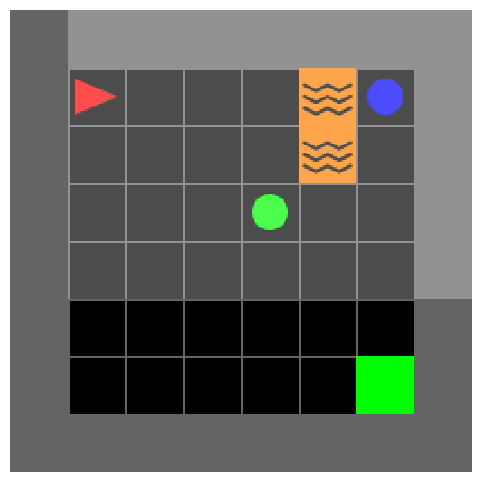

Board 2
(resert env)   kwargs={'unique_env': 2}
generate unique env number-2
<class 'numpy.ndarray'> (256, 256, 3)


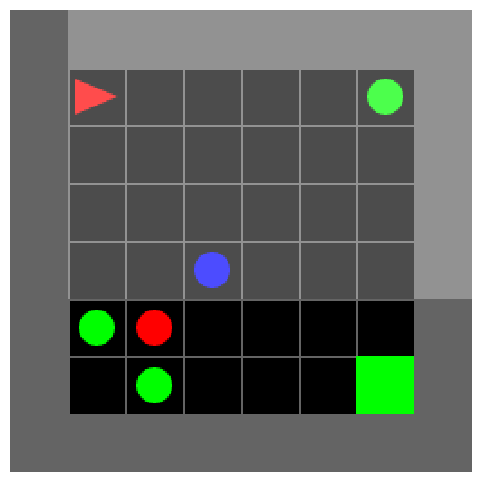

Board 3
(resert env)   kwargs={'unique_env': 3}
generate unique env number-3
<class 'numpy.ndarray'> (256, 256, 3)


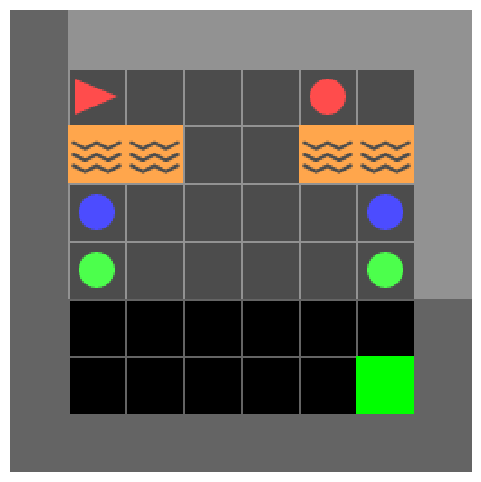

Board 4
(resert env)   kwargs={'unique_env': 4}
generate unique env number-4
<class 'numpy.ndarray'> (256, 256, 3)


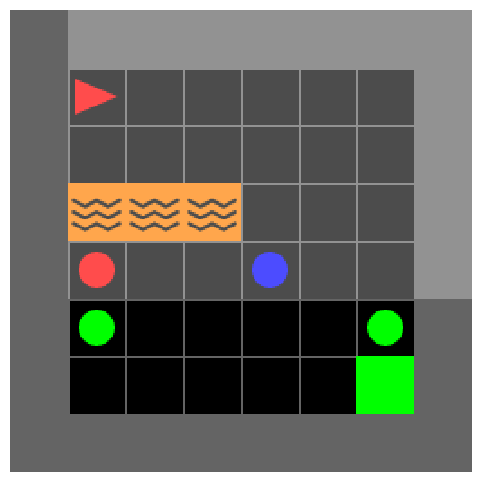

Board 5
(resert env)   kwargs={'unique_env': 5}
generate unique env number-5
<class 'numpy.ndarray'> (256, 256, 3)


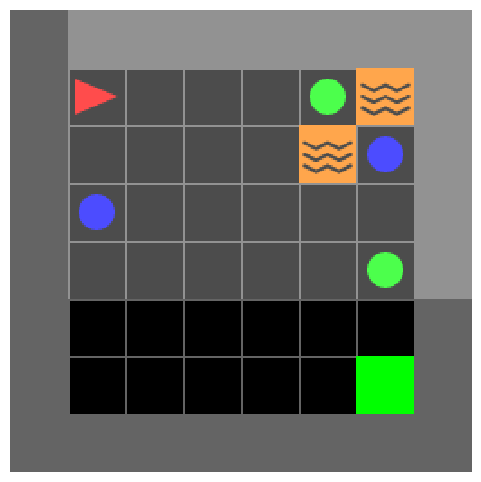

Board 6
(resert env)   kwargs={'unique_env': 6}
generate unique env number-6
<class 'numpy.ndarray'> (256, 256, 3)


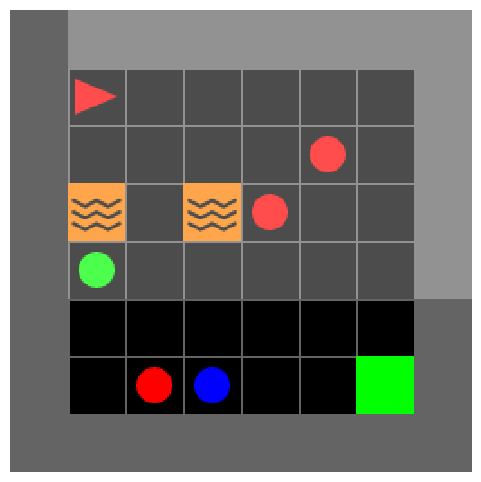

Board 7
(resert env)   kwargs={'unique_env': 7}
generate unique env number-7
<class 'numpy.ndarray'> (256, 256, 3)


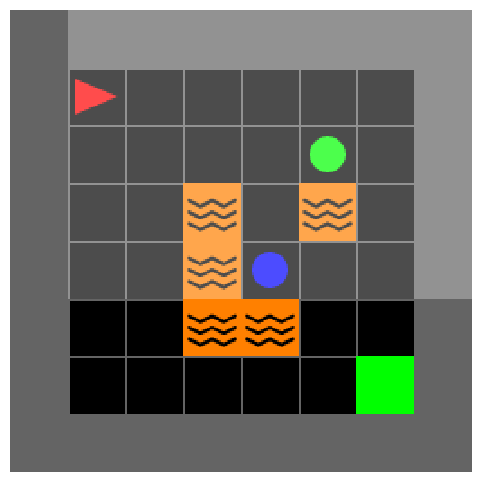

Board 8
(resert env)   kwargs={'unique_env': 8}
generate unique env number-8
<class 'numpy.ndarray'> (256, 256, 3)


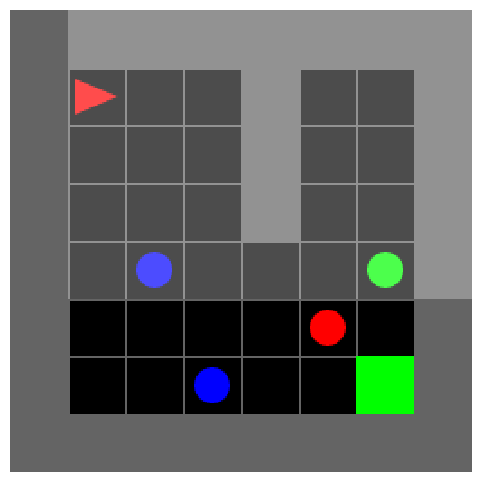

Board 9
(resert env)   kwargs={'unique_env': 9}
generate unique env number-9
<class 'numpy.ndarray'> (256, 256, 3)


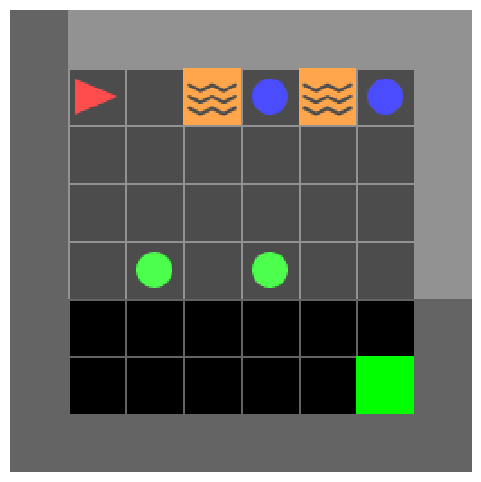

Board 10
(resert env)   kwargs={'unique_env': 10}
generate unique env number-10
<class 'numpy.ndarray'> (256, 256, 3)


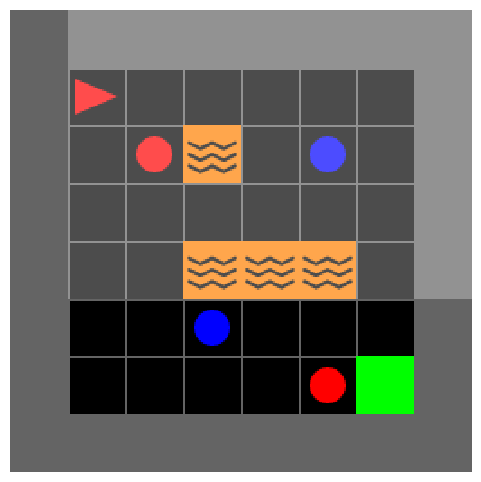

Board 11
(resert env)   kwargs={'unique_env': 11}
generate unique env number-11
<class 'numpy.ndarray'> (256, 256, 3)


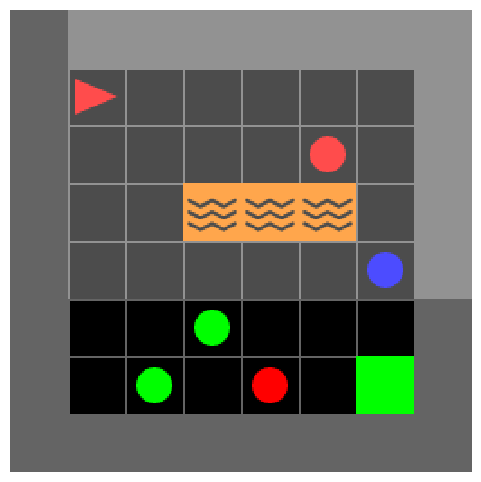

Board 12
(resert env)   kwargs={'unique_env': 12}
generate unique env number-12
<class 'numpy.ndarray'> (256, 256, 3)


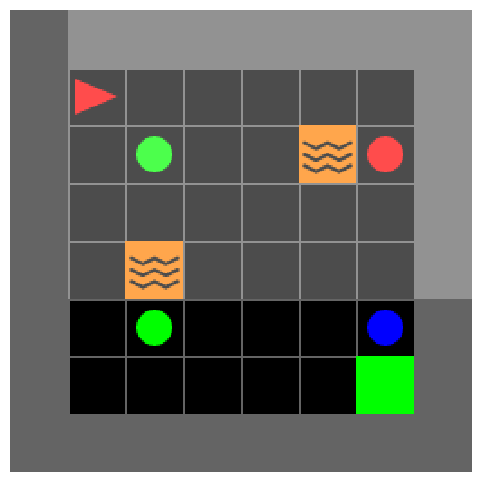

Board 13
(resert env)   kwargs={'unique_env': 13}
generate unique env number-13
<class 'numpy.ndarray'> (256, 256, 3)


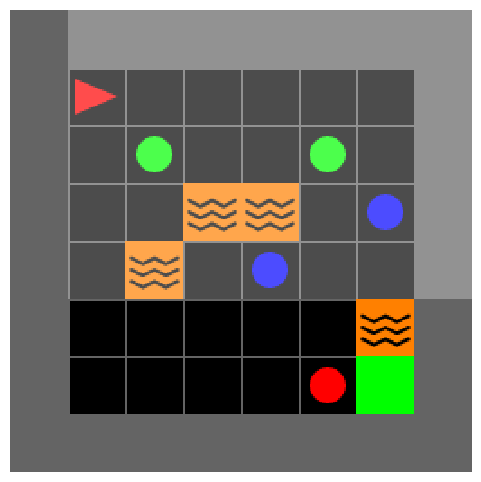

Board 14
(resert env)   kwargs={'unique_env': 14}
generate unique env number-14
<class 'numpy.ndarray'> (256, 256, 3)


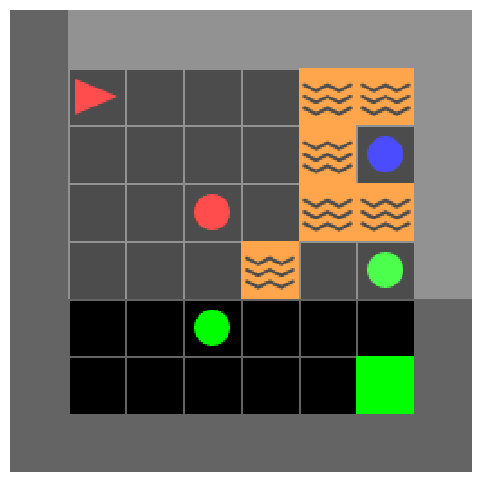

In [ ]:
env_name = "-1,3,4,-3,0.1Steps60Grid8_20250618"

env = create_env_from_model(
    model_name=env_name,
    grid_size=grid_size,
    agent_view_size=agent_view_size,
    max_steps=50,
    highlight=True,
    num_objects=5,
    lava_cells=5,
    train_env=False,
    image_full_view=False,
    )    
import os
model_path = os.path.join("models", env_name, "best_model")
agent = load_agent(env, model_path)
for i in range(1, 15):  # Three episodes
    print(f"Board {i}")
    initial_k = {'unique_env': i}
    current_obs = env.unwrapped.reset(**initial_k)
    plot_state(env)

## Demonstrate env diffrences


In [ ]:
import numpy as np
import os

new_models_dict = {
    1: {'path': 'models/3,3,3,0.1,0.1Steps100Grid8_20250602/best_model.zip', 'name': 'AllColorsLL1_0526', 'vector': (3, 3, 3, 0.1, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
    2: {'path': 'models/3,3,4,0.2,0.05Steps50Grid8_20250604/best_model.zip', 'name': 'AllColorsLL2_0604', 'vector': (3, 3, 4, 0.2, 0.05), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13]},
    3: {'path': 'models/2,2,4,-4,0.1Steps50Grid8_20250617/best_model.zip', 'name': 'AllColorsLH_0617', 'vector': (2, 2, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14]},
    4: {'path': 'models/-1,-1,4,0.2,0.1Steps70Grid8_20250625/best_model.zip', 'name': 'OnlyBlueLL_0625', 'vector': (-1, -1, 4, 0.2, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
    5: {'path': 'models/-0.5,2,4,-3,0.1Steps50Grid8_20250612_good/best_model.zip', 'name': 'NoRedLH1_0612', 'vector': (-0.5, 2, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 14]},
    6: {'path': 'models/-0.5,3,4,0.2,0.1Steps50Grid8_20250616/best_model.zip', 'name': 'NoRedLL_0616', 'vector': (-0.5, 3, 4, 0.2, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
    7: {'path': 'models/-1,4,-1,0.2,0.1Steps60Grid8_20250618/best_model', 'name': 'OnlyGreenLL_0429', 'vector': (-0.1, 3, -0.1, 0, 0.01), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]},
    8: {'path': 'models/-1,3,4,-3,0.1Steps60Grid8_20250618/best_model.zip', 'name': 'NoRedLH2_0618', 'vector': (-1, 3, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12]},
    9: {'path': 'models/-0.5,3,4,-3,0.1Steps50Grid8_20250616/best_model.zip', 'name': 'NoRedLH3_0612', 'vector': (-0.5, 3, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]},
    10: {'path': 'models/-1,3,4,0.2,0.2Steps50Grid8_20250617/best_model.zip', 'name': 'NoRedLL_G_0617', 'vector': (-1, 3, 4, 0.2, 0.2), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]},
    11: {'path': 'models/-1,-1,4,-3,0.1Steps100Grid8_20250706/best_model.zip', 'name': 'OnlyBlueLH_0706', 'vector': (-1, -1, 4, -3, 0.1), 'optional_unique_env': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 16, 17, 18]},
}

new_models_distance =  {1: [(2, 'AllColorsLL2_0604', 3), (3, 'AllColorsLH_0617', 3), (4, 'OnlyBlueLL_0625', 2), (7, 'OnlyGreenLL_0429', 2)],
    2: [(1, 'AllColorsLL1_0526', 3), (3, 'AllColorsLH_0617', 9), (4, 'OnlyBlueLL_0625', 3), (7, 'OnlyGreenLL_0429', 13)],
    3: [(1, 'AllColorsLL1_0526', 4), (11, 'OnlyBlueLH_0706', 2), (9, 'NoRedLH3_0612', 4), (2, 'AllColorsLL2_0604', 3)],
    4: [(7, 'OnlyGreenLL_0429', 2), (10, 'NoRedLL_G_0617', 9), (11, 'OnlyBlueLH_0706', 7), (2, 'AllColorsLL2_0604', 8)],
    5: [(9, 'NoRedLH3_0612', 1), (8, 'NoRedLH2_0618', 5), (3, 'AllColorsLH_0617', 4), (4, 'OnlyBlueLL_0625', 7)],
    6: [(10, 'NoRedLL_G_0617', 1), (8, 'NoRedLH2_0618', 1), (5, 'NoRedLH1_0612', 3), (9, 'NoRedLH3_0612', 4)],
    7: [(6, 'NoRedLL_0616', 13), (10, 'NoRedLL_G_0617', 5), (8, 'NoRedLH2_0618', 6), (9, 'NoRedLH3_0612', 6)],
    8: [(9, 'NoRedLH3_0612', 1), (5, 'NoRedLH1_0612', 4), (11, 'OnlyBlueLH_0706', 4), (3, 'AllColorsLH_0617', 11)],
    9: [(8, 'NoRedLH2_0618', 1), (5, 'NoRedLH1_0612', 5), (3, 'AllColorsLH_0617', 3), (4, 'OnlyBlueLL_0625', 7)],
    10: [(6, 'NoRedLL_0616', 1), (8, 'NoRedLH2_0618', 3), (9, 'NoRedLH3_0612', 3), (5, 'NoRedLH1_0612', 3), (3, 'AllColorsLH_0617', 8)],
    11: [(3, 'AllColorsLH_0617', 12), (4, 'OnlyBlueLL_0625', 9), (9, 'NoRedLH3_0612', 17), (5, 'NoRedLH1_0612', 9)],}


def get_episode_score(model_path, env, unique_env):
    initial_k = {'unique_env': unique_env}
    current_obs = env.unwrapped.reset(**initial_k)
    current_obs = {'image': current_obs[0]['image']}

    agent = PPO.load(model_path)
    done = False
    truncated = False
    score = 0
    while not (done or truncated):  # Limit to 50 steps per episode
        action, _ = agent.predict(current_obs, deterministic=True)
        current_obs, reward, done, truncated, _ = env.step(action)
        current_obs = {'image': current_obs['image']}
        score += reward
    return score, truncated
        

base_env_name = "-1,-1,4,-3,0.1Steps100Grid8_20250706"
env = create_env_from_model(base_env_name,
                grid_size=8,
                 agent_view_size=7,
                 max_steps=50,
                 highlight=True,
                 num_objects=5,
                 lava_cells=8,
                 train_env=False)      


# for model_idx, neighbors in new_models_distance.items():
#     for i, neighbor in enumerate(neighbors):
#         (neighbor_idx, neighbor_name) = neighbor[0:2]
#         max_diff = 0
#         max_env = 1
#         for unique_env in range(1, 15):
#             score1, truncated1 = get_episode_score(new_models_dict[model_idx]['path'], env, unique_env)
#             other_path = new_models_dict[neighbor_idx]['path']
#             score2, truncated2 = get_episode_score(other_path, env, unique_env)
#             if truncated1 or truncated2:
#                 continue
#             diff = abs(score1 - score2)
#             if diff > max_diff:
#                 max_diff = diff
#                 max_env = unique_env
#         new_models_distance[model_idx][i] = (neighbor_idx, neighbor_name, max_env)
        

# Now new_models_distance has (neighbor_idx, neighbor_name, unique_env, max_diff) for each neighbor
print(new_models_distance)

{1: [(2, 'AllColorsLL2_0604', 3), (3, 'AllColorsLH_0617', 7), (4, 'OnlyBlueLL_0625', 2), (7, 'OnlyGreenLL_0429', 2)], 2: [(1, 'AllColorsLL1_0526', 3), (3, 'AllColorsLH_0617', 9), (4, 'OnlyBlueLL_0625', 3), (7, 'OnlyGreenLL_0429', 13)], 3: [(1, 'AllColorsLL1_0526', 4), (11, 'OnlyBlueLH_0706', 2), (9, 'NoRedLH3_0612', 4), (2, 'AllColorsLL2_0604', 3)], 4: [(7, 'OnlyGreenLL_0429', 2), (10, 'NoRedLL_G_0617', 9), (11, 'OnlyBlueLH_0706', 7), (2, 'AllColorsLL2_0604', 8)], 5: [(9, 'NoRedLH3_0612', 1), (8, 'NoRedLH2_0618', 5), (3, 'AllColorsLH_0617', 4), (4, 'OnlyBlueLL_0625', 7)], 6: [(10, 'NoRedLL_G_0617', 1), (8, 'NoRedLH2_0618', 1), (5, 'NoRedLH1_0612', 3), (9, 'NoRedLH3_0612', 4)], 7: [(6, 'NoRedLL_0616', 13), (10, 'NoRedLL_G_0617', 5), (8, 'NoRedLH2_0618', 6), (9, 'NoRedLH3_0612', 6)], 8: [(9, 'NoRedLH3_0612', 1), (5, 'NoRedLH1_0612', 4), (11, 'OnlyBlueLH_0706', 4), (3, 'AllColorsLH_0617', 11)], 9: [(8, 'NoRedLH2_0618', 1), (5, 'NoRedLH1_0612', 11), (3, 'AllColorsLH_0617', 3), (4, 'OnlyBlu

unique_env 1
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-1
Function 'capture_agent_path' took 0.0835 seconds.
Function 'plot_all_move_sequence' took 0.7288 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-1
Function 'capture_agent_path' took 0.0500 seconds.
Function 'plot_all_move_sequence' took 0.4632 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-1

AllColorsLL1_0526 path: (-2.2, False)



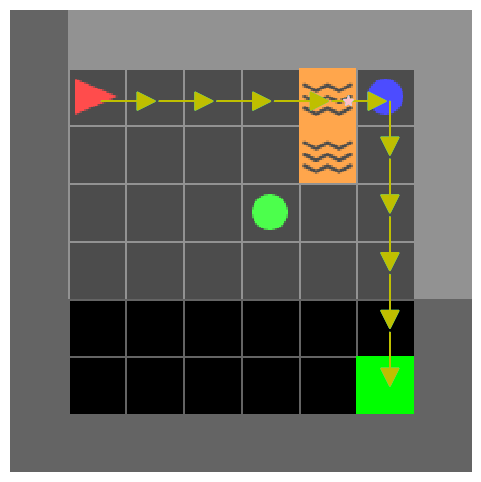

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-1
AllColorsLH_0617 path: (5.500000000000002, False)



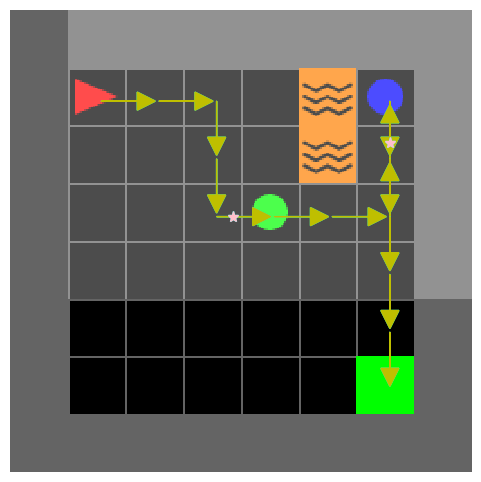

unique_env 2
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-2
Function 'capture_agent_path' took 0.1493 seconds.
Function 'plot_all_move_sequence' took 1.0679 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-2
Function 'capture_agent_path' took 0.0904 seconds.
Function 'plot_all_move_sequence' took 0.6264 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-2

AllColorsLL1_0526 path: (7.8000000000000025, False)



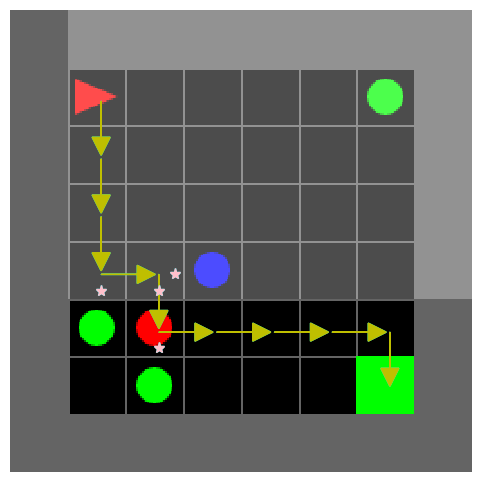

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-2
AllColorsLH_0617 path: (9.200000000000006, False)



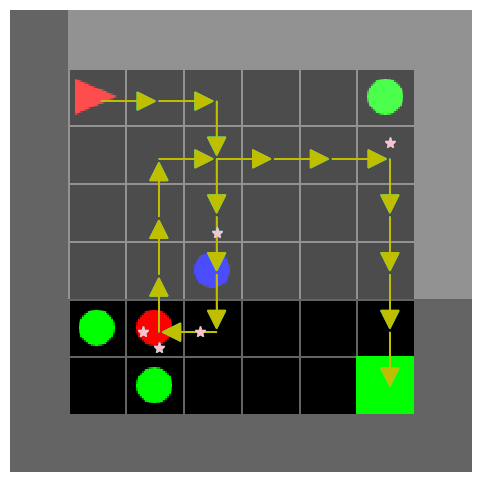

unique_env 3
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-3
Function 'capture_agent_path' took 0.1249 seconds.
Function 'plot_all_move_sequence' took 0.9423 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-3
Function 'capture_agent_path' took 0.0687 seconds.
Function 'plot_all_move_sequence' took 0.6414 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-3

AllColorsLL1_0526 path: (7.199999999999999, False)



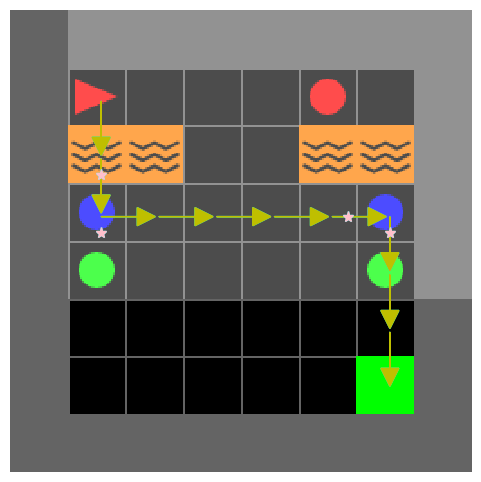

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-3
AllColorsLH_0617 path: (10.700000000000003, False)



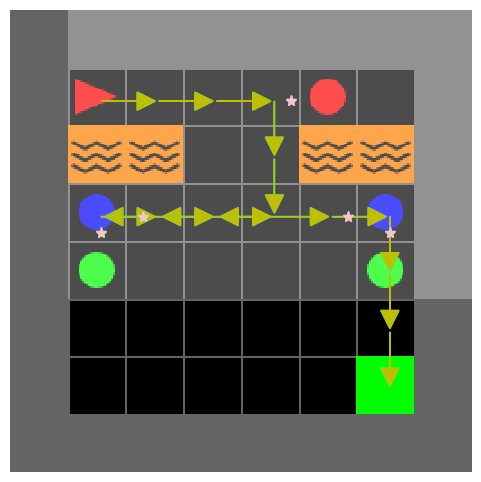

unique_env 4
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-4
Function 'capture_agent_path' took 0.1152 seconds.
Function 'plot_all_move_sequence' took 0.9888 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-4
Function 'capture_agent_path' took 0.0864 seconds.
Function 'plot_all_move_sequence' took 0.6116 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-4

AllColorsLL1_0526 path: (2.2, False)



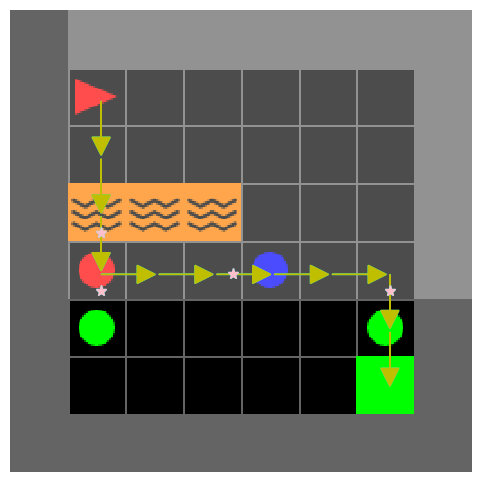

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-4
AllColorsLH_0617 path: (-1.9000000000000008, False)



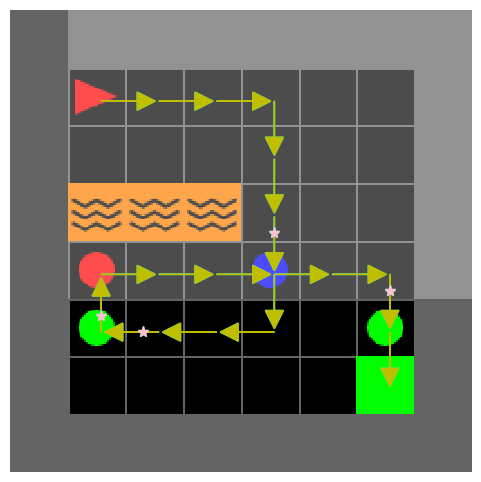

unique_env 5
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-5
Function 'capture_agent_path' took 0.1628 seconds.
Function 'plot_all_move_sequence' took 1.2139 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-5
Function 'capture_agent_path' took 0.1334 seconds.
Function 'plot_all_move_sequence' took 0.6114 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-5

AllColorsLL1_0526 path: (-4.899999999999999, False)



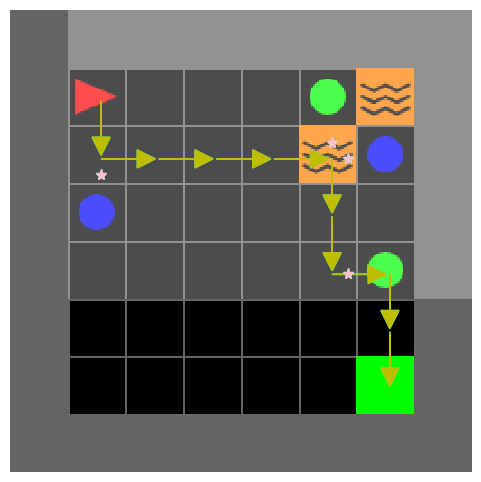

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-5
AllColorsLH_0617 path: (1.8000000000000045, False)



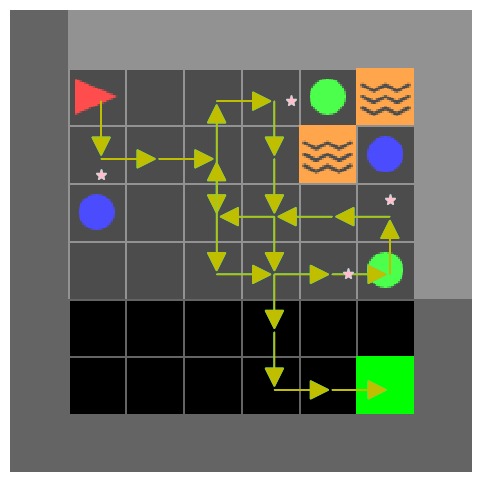

unique_env 6
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-6
reached max steps=50
Function 'capture_agent_path' took 0.2146 seconds.
Function 'plot_all_move_sequence' took 0.4011 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-6
Function 'capture_agent_path' took 0.0864 seconds.
Function 'plot_all_move_sequence' took 0.6319 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-6

AllColorsLL1_0526 path: (-13.8, False)



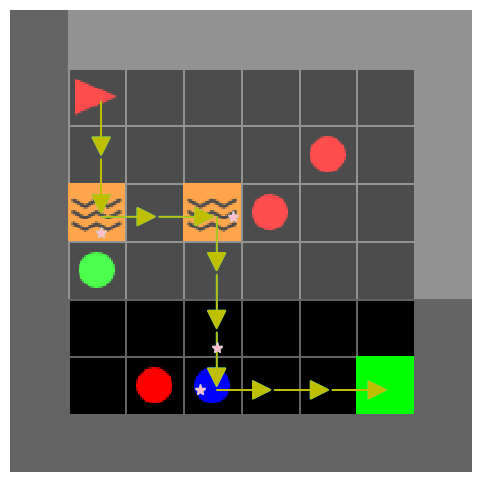

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-6
reached max steps=50
AllColorsLH_0617 path: (-6.99999999999999, True)



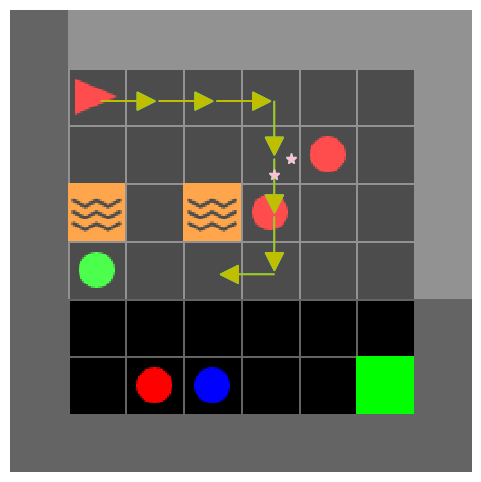

unique_env 7
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-7
Function 'capture_agent_path' took 0.0689 seconds.
Function 'plot_all_move_sequence' took 0.5196 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-7
Function 'capture_agent_path' took 0.0866 seconds.
Function 'plot_all_move_sequence' took 0.7124 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-7

AllColorsLL1_0526 path: (-6.099999999999998, False)



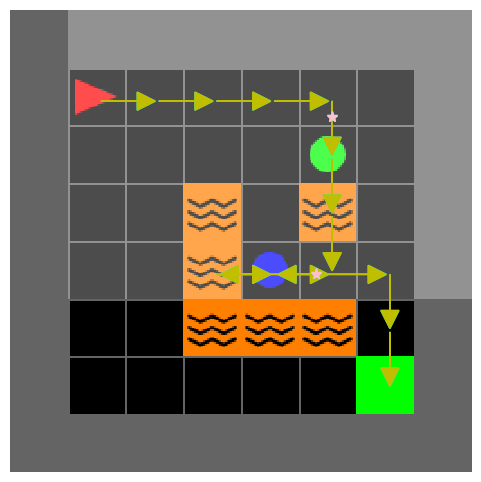

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-7
AllColorsLH_0617 path: (0.2999999999999995, False)



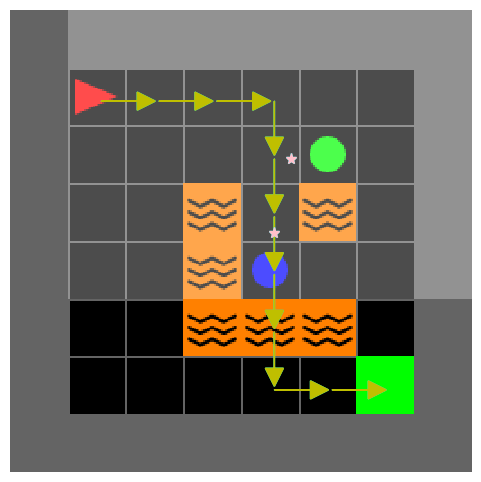

unique_env 8
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-8
Function 'capture_agent_path' took 0.0944 seconds.
Function 'plot_all_move_sequence' took 0.6176 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-8
Function 'capture_agent_path' took 0.0726 seconds.
Function 'plot_all_move_sequence' took 0.5649 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-8

AllColorsLL1_0526 path: (6.000000000000002, False)



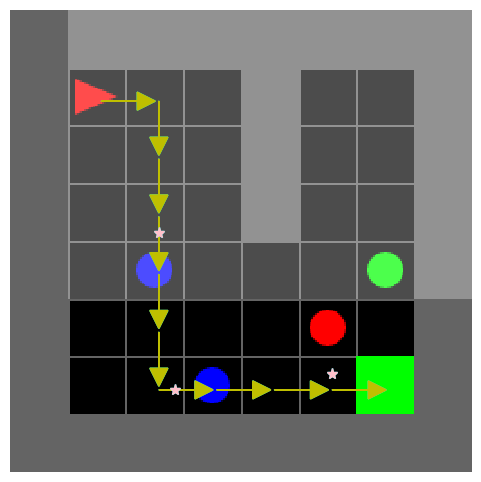

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-8
AllColorsLH_0617 path: (8.500000000000002, False)



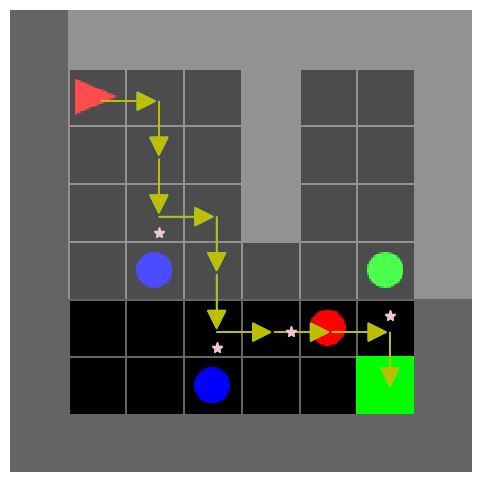

unique_env 9
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-9
Function 'capture_agent_path' took 0.0935 seconds.
Function 'plot_all_move_sequence' took 0.7415 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-9
Function 'capture_agent_path' took 0.0671 seconds.
Function 'plot_all_move_sequence' took 0.5205 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-9

AllColorsLL1_0526 path: (-6.999999999999998, False)



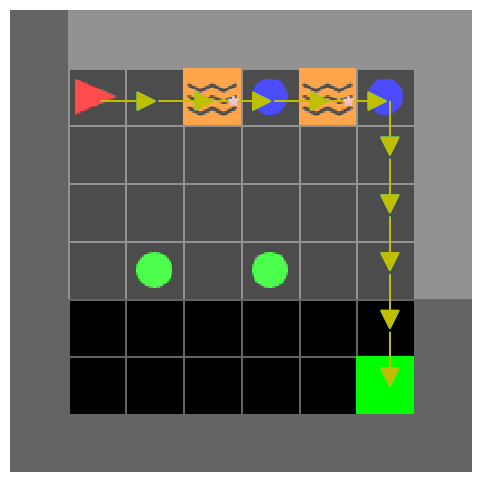

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-9
AllColorsLH_0617 path: (2.599999999999999, False)



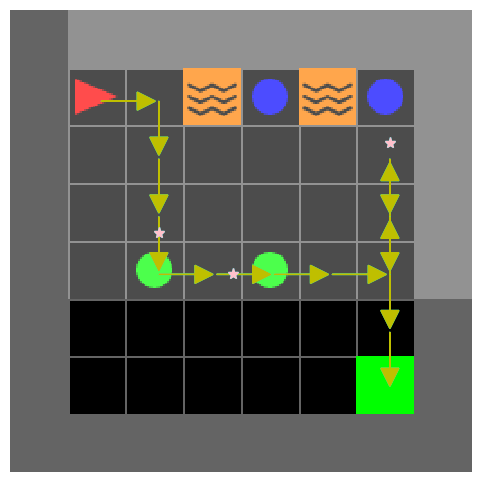

unique_env 10
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-10
Function 'capture_agent_path' took 0.1036 seconds.
Function 'plot_all_move_sequence' took 0.5738 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-10
Function 'capture_agent_path' took 0.0883 seconds.
Function 'plot_all_move_sequence' took 0.5703 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-10

AllColorsLL1_0526 path: (-7.700000000000001, False)



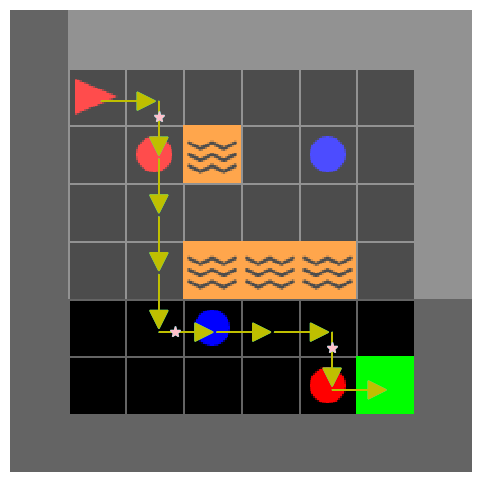

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-10
AllColorsLH_0617 path: (0.799999999999999, False)



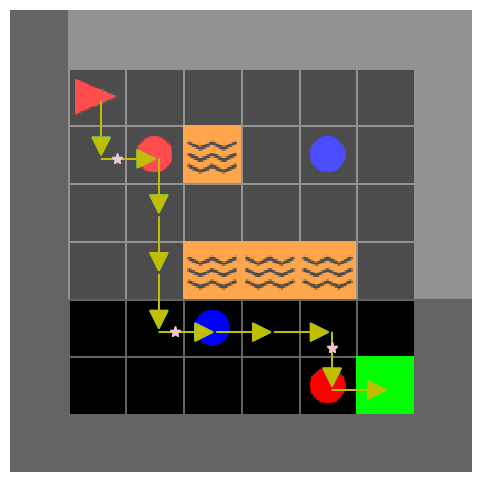

unique_env 11
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-11
Function 'capture_agent_path' took 0.1557 seconds.
Function 'plot_all_move_sequence' took 1.0947 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-11
Function 'capture_agent_path' took 0.1173 seconds.
Function 'plot_all_move_sequence' took 0.9580 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-11

AllColorsLL1_0526 path: (-0.19999999999999785, False)



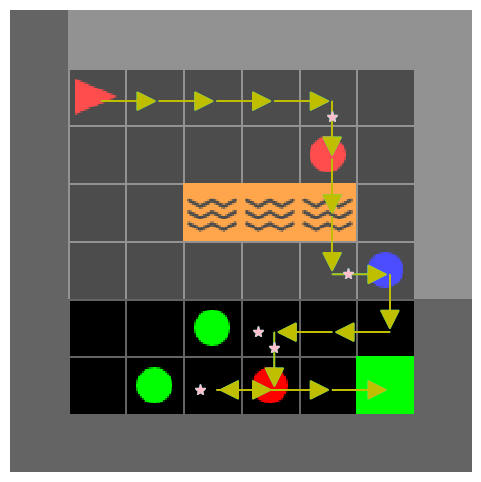

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-11
AllColorsLH_0617 path: (-5.399999999999996, False)



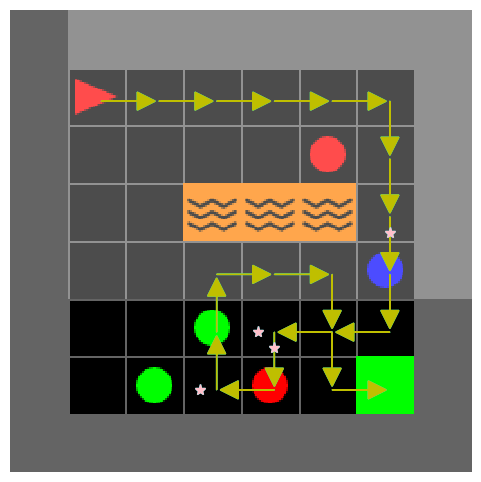

unique_env 12
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-12
Function 'capture_agent_path' took 0.0927 seconds.
Function 'plot_all_move_sequence' took 0.7980 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-12
Function 'capture_agent_path' took 0.0757 seconds.
Function 'plot_all_move_sequence' took 0.6081 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-12

AllColorsLL1_0526 path: (-2.4999999999999996, False)



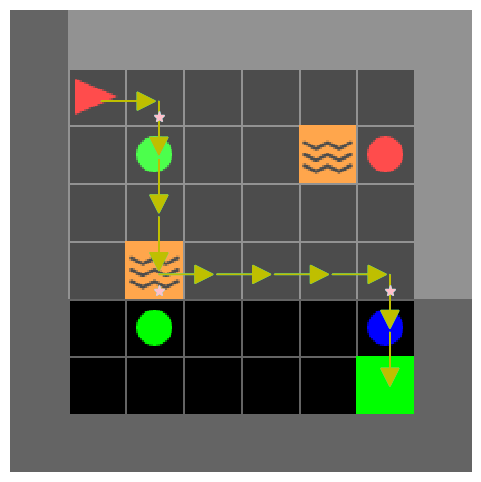

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-12
AllColorsLH_0617 path: (7.100000000000003, False)



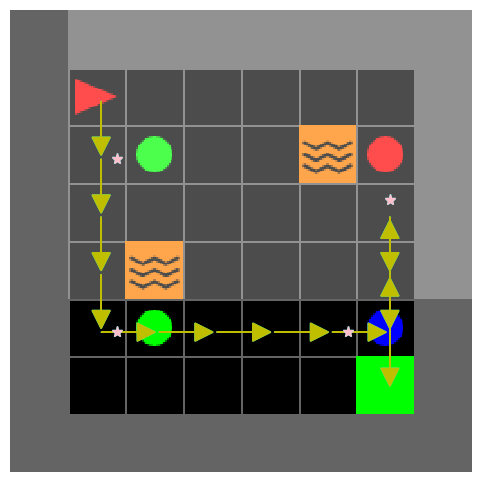

unique_env 13
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-13
reached max steps=50
Function 'capture_agent_path' took 0.1963 seconds.
Function 'plot_all_move_sequence' took 0.2115 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-13
Function 'capture_agent_path' took 0.0735 seconds.
Function 'plot_all_move_sequence' took 0.6242 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-13

AllColorsLL1_0526 path: (3.2999999999999994, False)



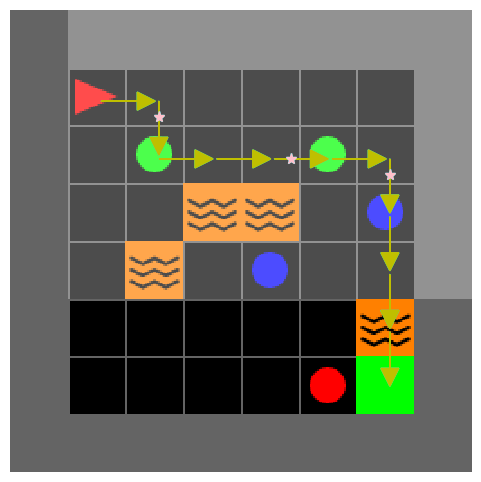

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-13
reached max steps=50
AllColorsLH_0617 path: (-46.000000000000036, True)



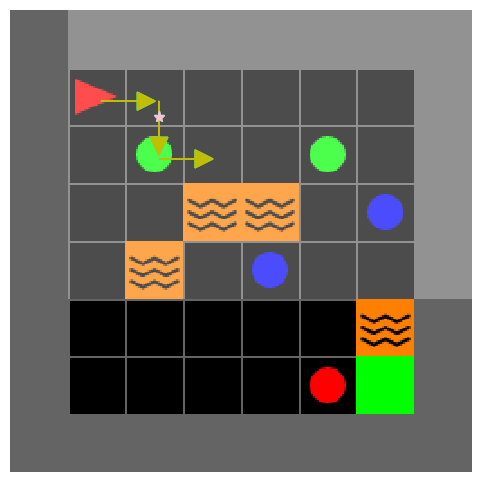

unique_env 14
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-14
Function 'capture_agent_path' took 0.0598 seconds.
Function 'plot_all_move_sequence' took 0.5598 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-14
Function 'capture_agent_path' took 0.1192 seconds.
Function 'plot_all_move_sequence' took 1.1109 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-14

AllColorsLL1_0526 path: (-16.6, False)



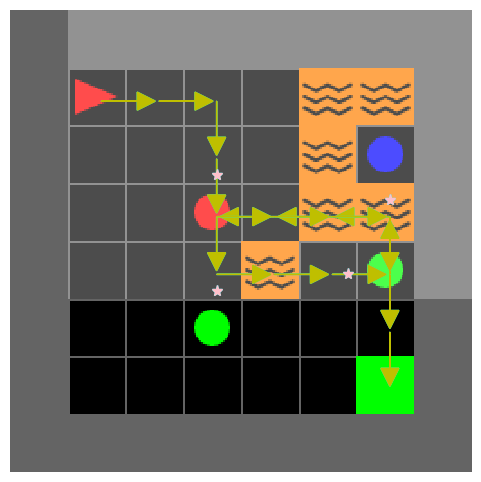

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-14
AllColorsLH_0617 path: (-4.5, False)



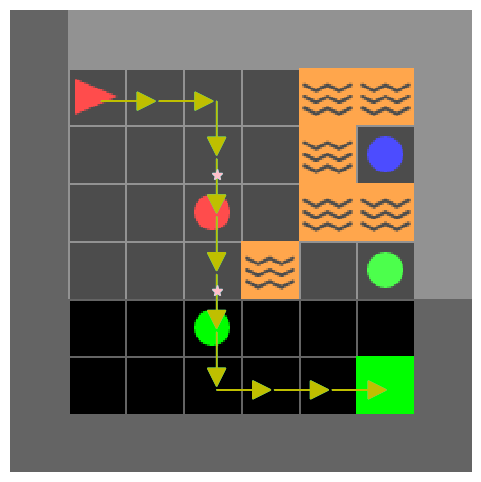

unique_env 15
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15
Function 'capture_agent_path' took 0.1173 seconds.
Function 'plot_all_move_sequence' took 0.9914 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15
Function 'capture_agent_path' took 0.0884 seconds.
Function 'plot_all_move_sequence' took 0.7167 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15

AllColorsLL1_0526 path: (0.8999999999999992, False)



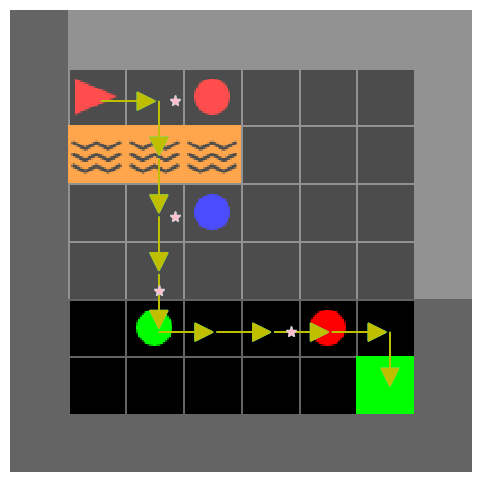

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-15
AllColorsLH_0617 path: (-2.699999999999999, False)



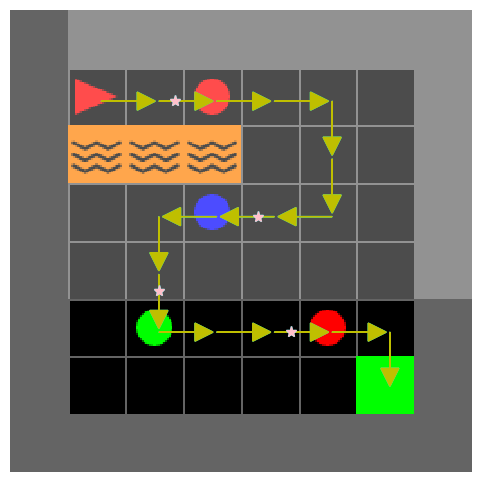

unique_env 16
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-16
Function 'capture_agent_path' took 0.1398 seconds.
Function 'plot_all_move_sequence' took 1.5080 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-16
Function 'capture_agent_path' took 0.1302 seconds.
Function 'plot_all_move_sequence' took 1.1551 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-16

AllColorsLL1_0526 path: (-0.49999999999999656, False)



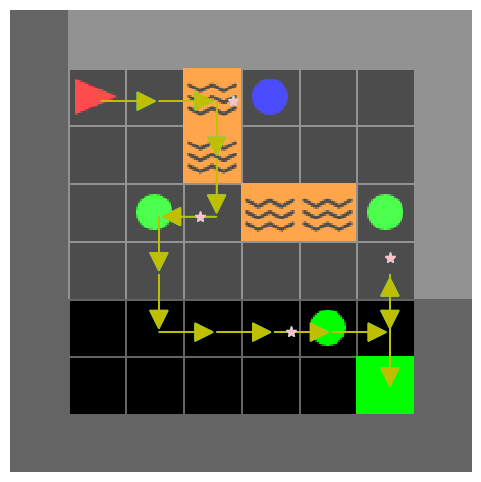

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-16
AllColorsLH_0617 path: (9.900000000000007, False)



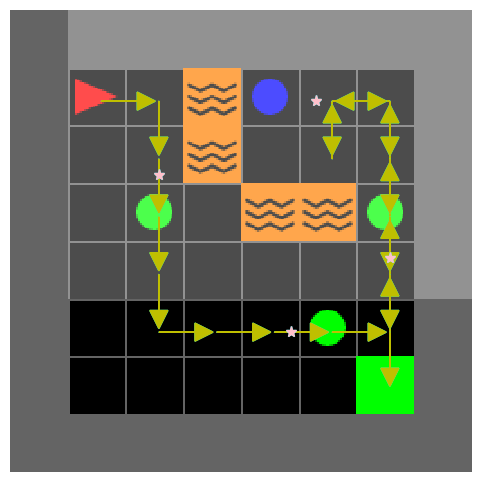

unique_env 17
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-17
Function 'capture_agent_path' took 0.0791 seconds.
Function 'plot_all_move_sequence' took 0.9172 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-17
Function 'capture_agent_path' took 0.1528 seconds.
Function 'plot_all_move_sequence' took 1.2864 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-17

AllColorsLL1_0526 path: (-9.1, False)



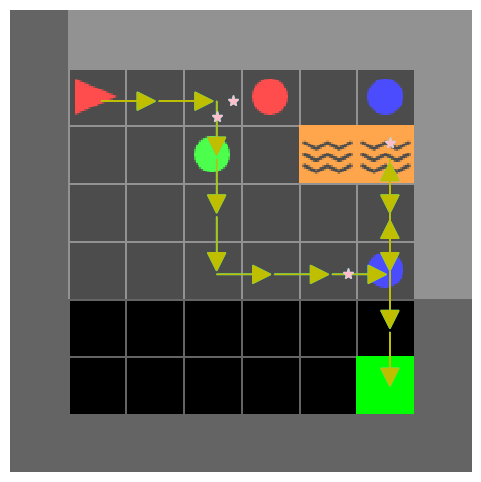

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-17
AllColorsLH_0617 path: (5.1, False)



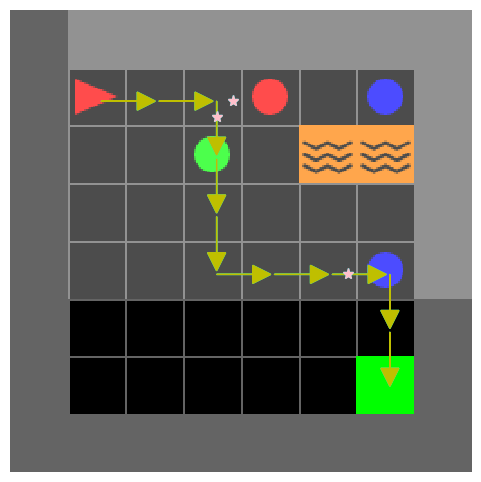

unique_env 18
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-18
reached max steps=50
Function 'capture_agent_path' took 0.4079 seconds.
Function 'plot_all_move_sequence' took 3.8210 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-18
Function 'capture_agent_path' took 0.1644 seconds.
Function 'plot_all_move_sequence' took 1.4240 seconds.
(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-18

AllColorsLL1_0526 path: (2.7999999999999985, False)



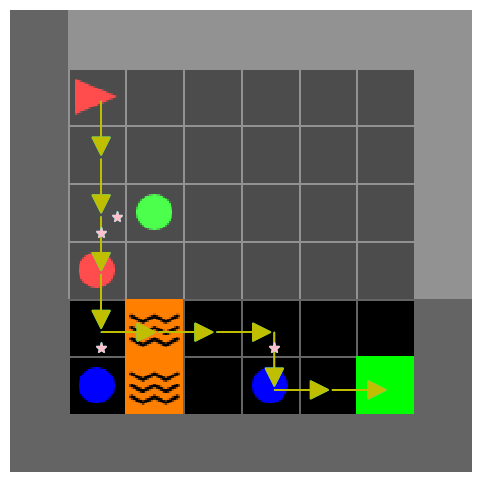

(reset) self.optional_unique_env: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
generate unique env number-18
reached max steps=50
AllColorsLH_0617 path: (1.0, True)



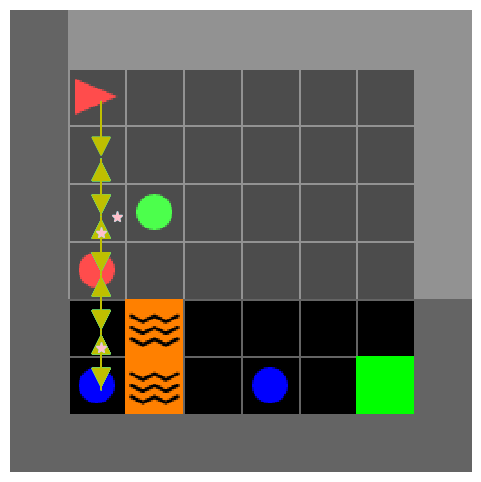

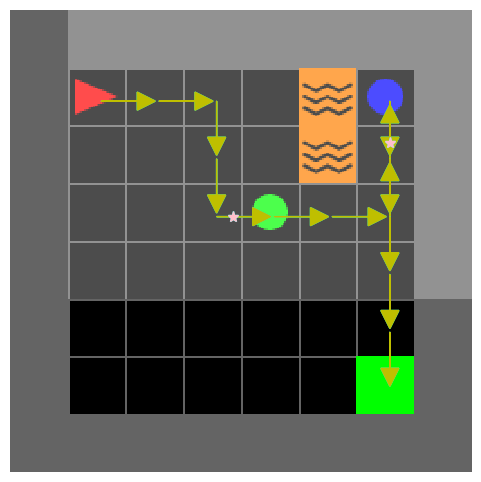

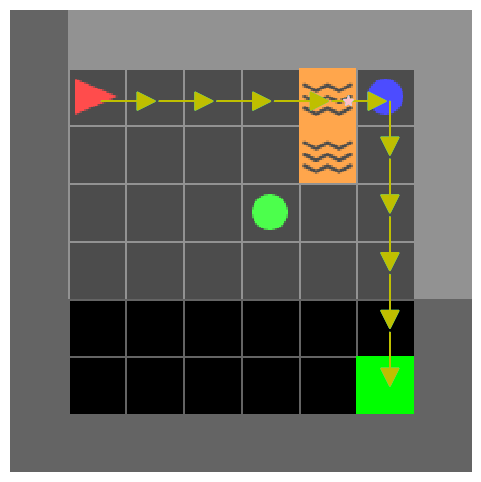

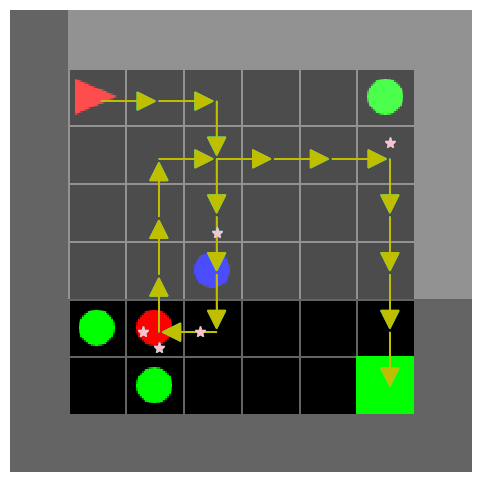

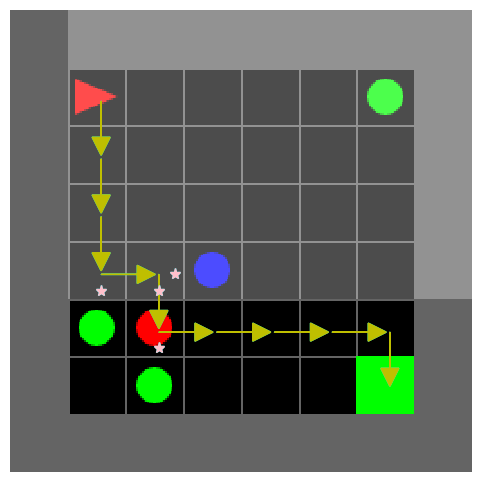

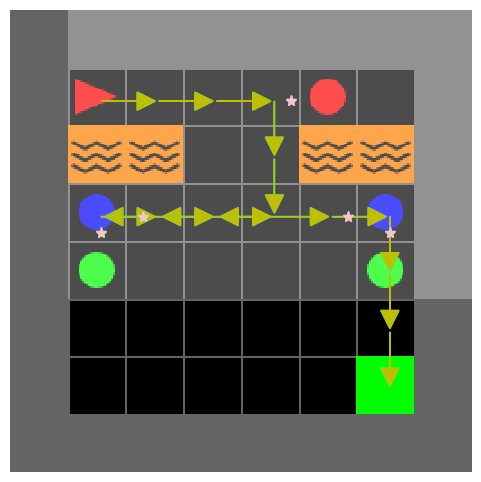

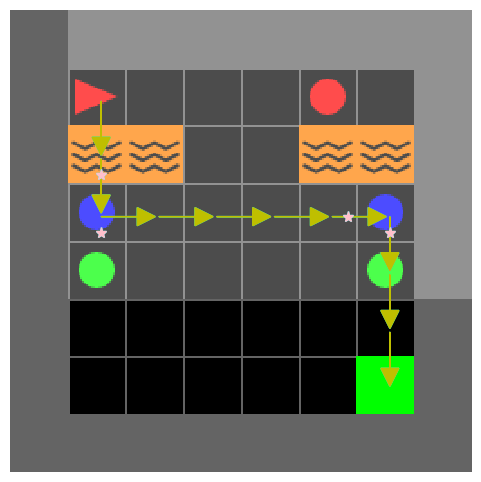

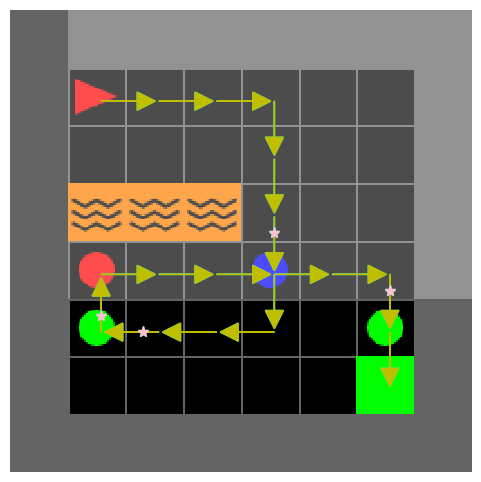

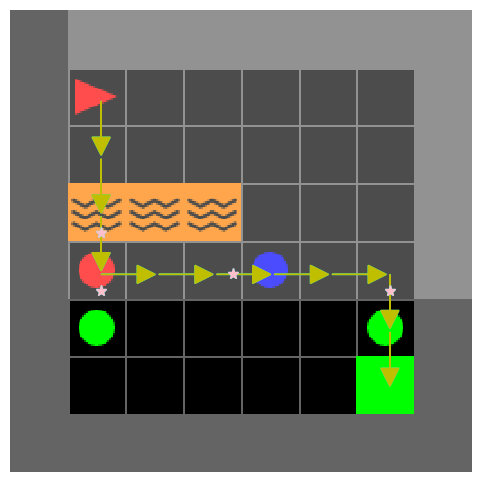

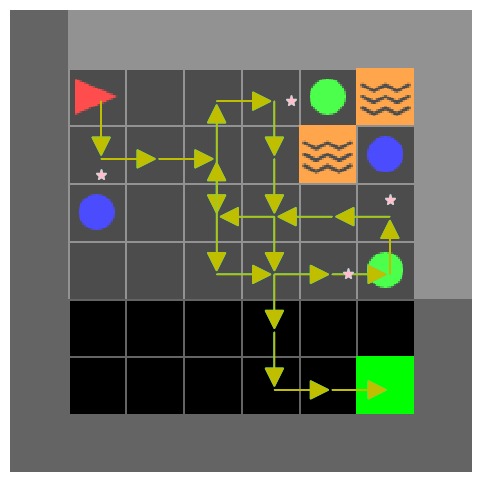

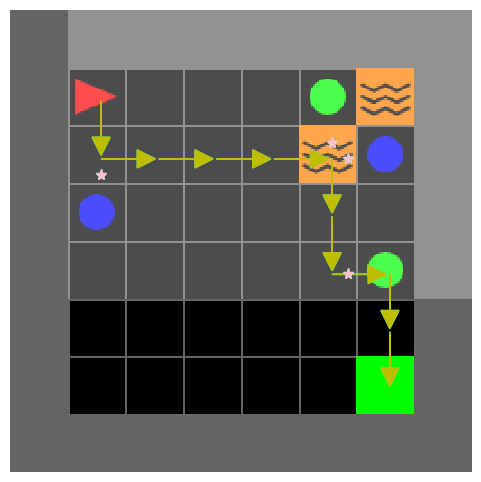

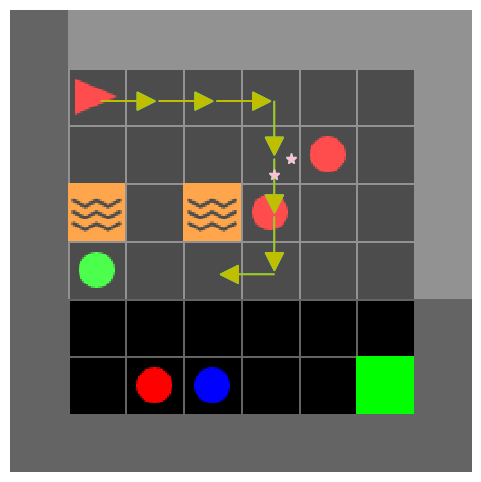

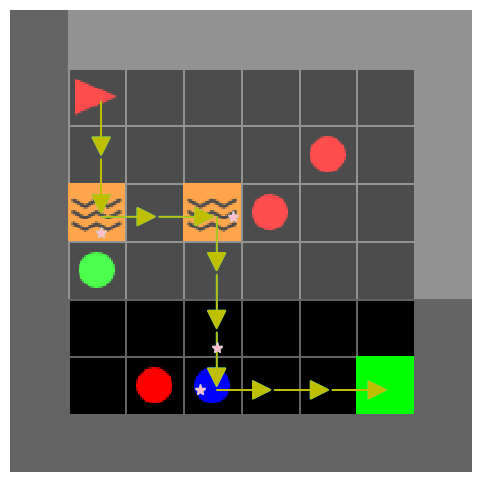

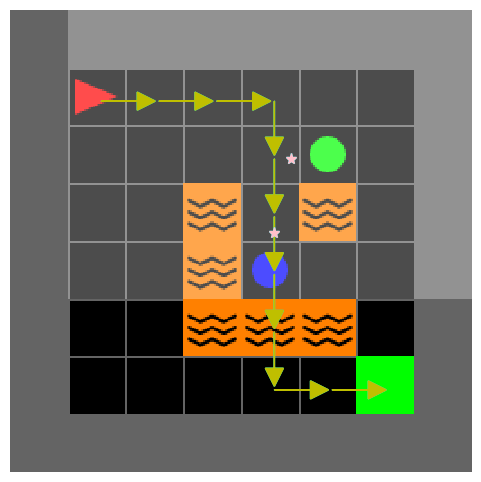

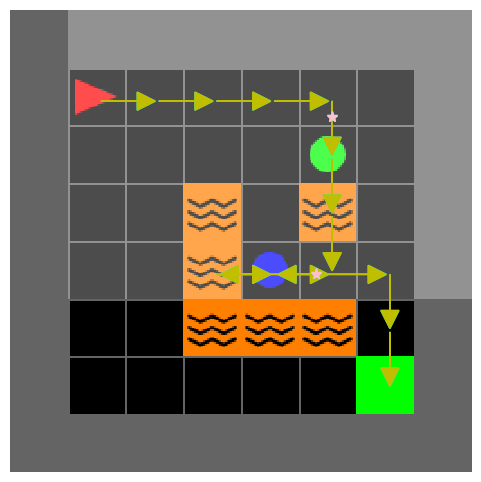

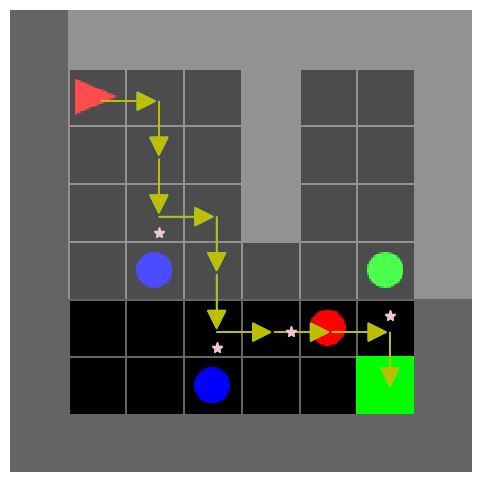

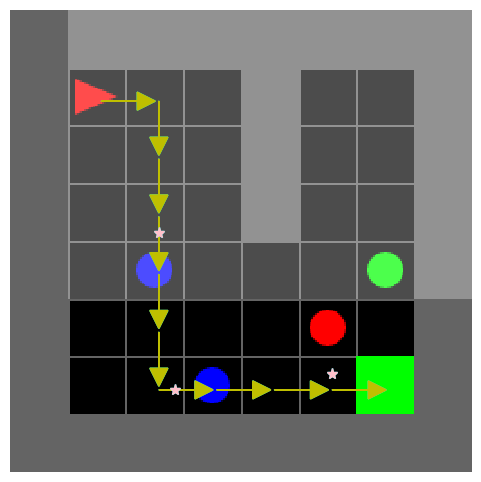

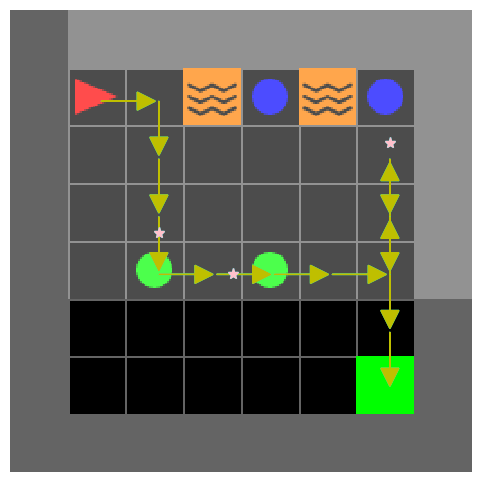

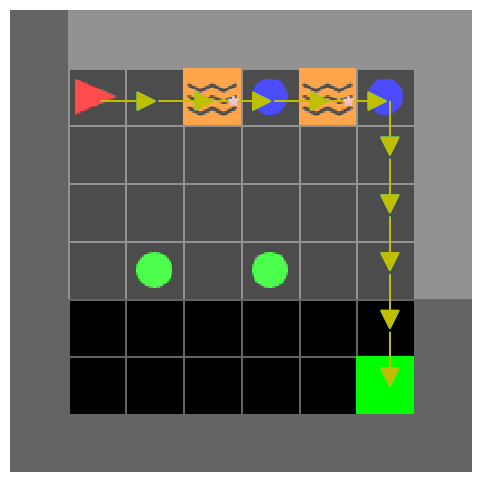

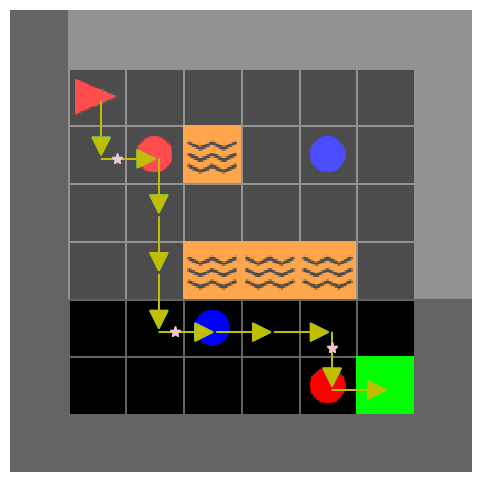

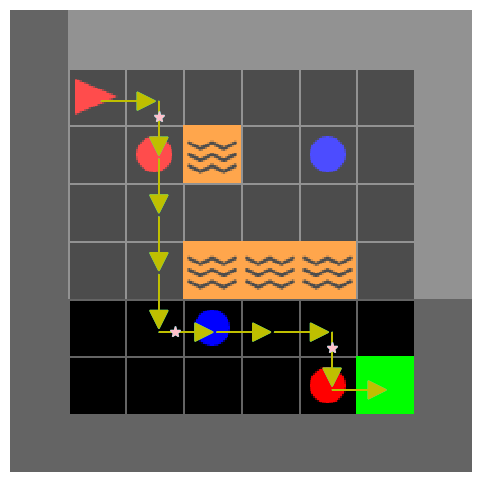

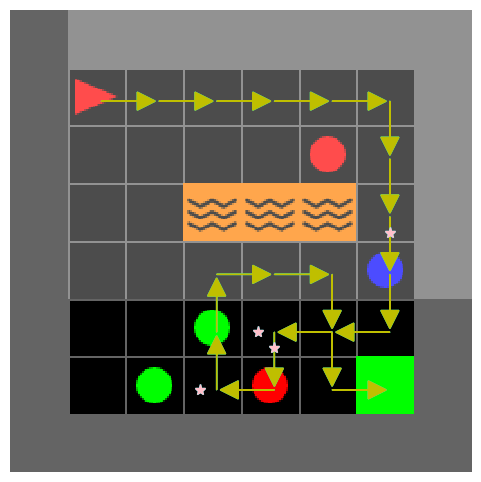

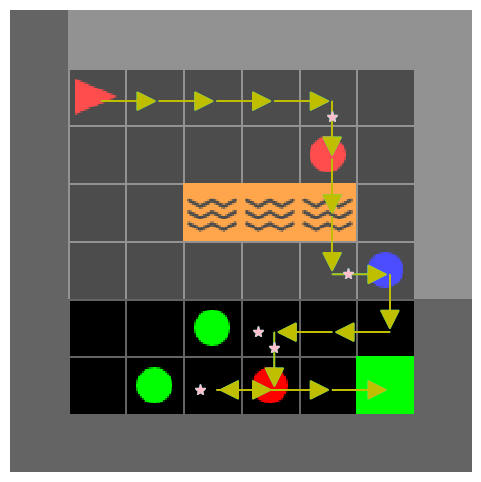

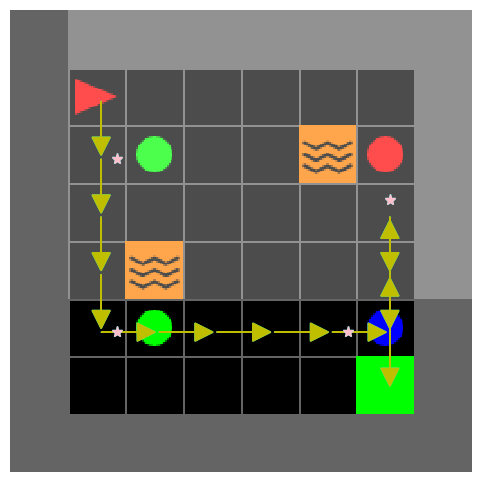

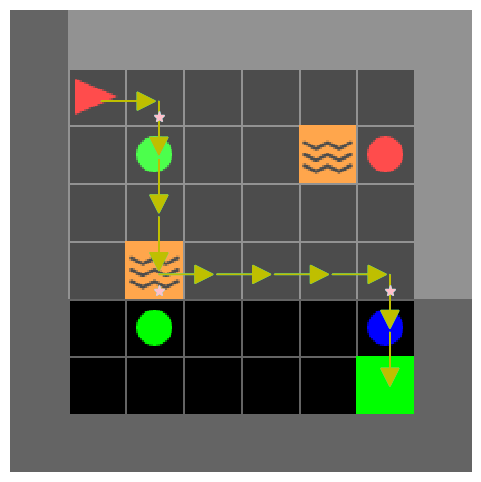

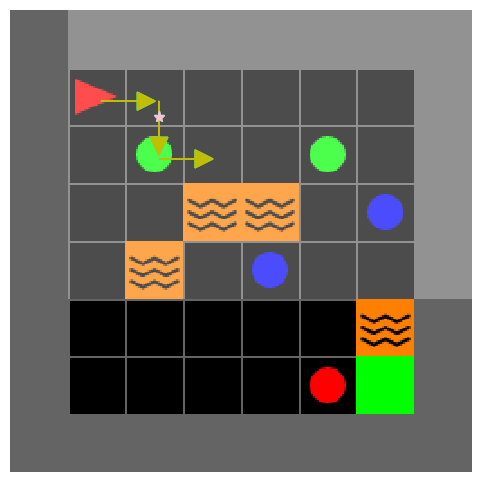

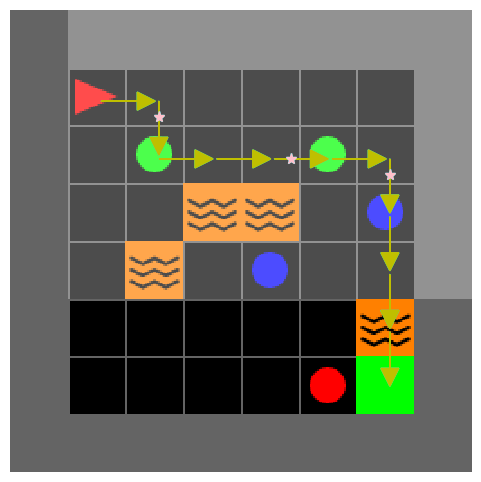

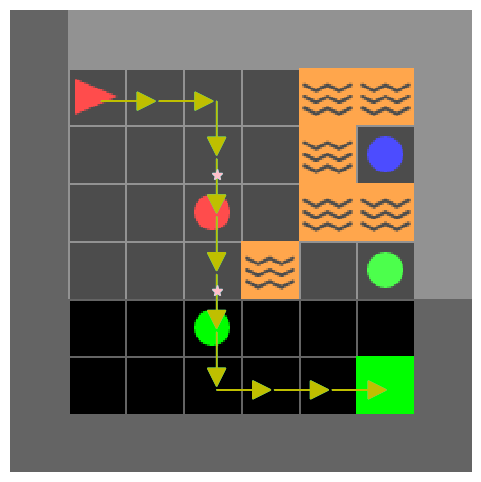

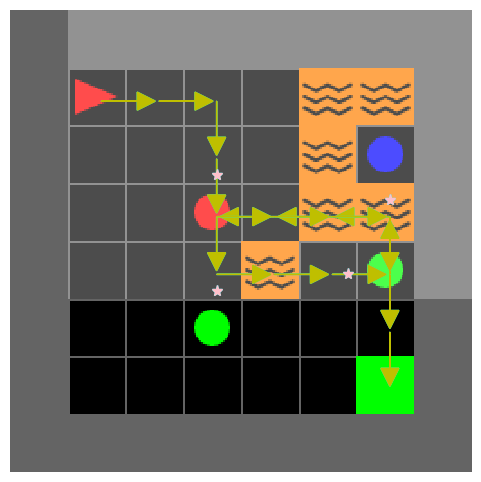

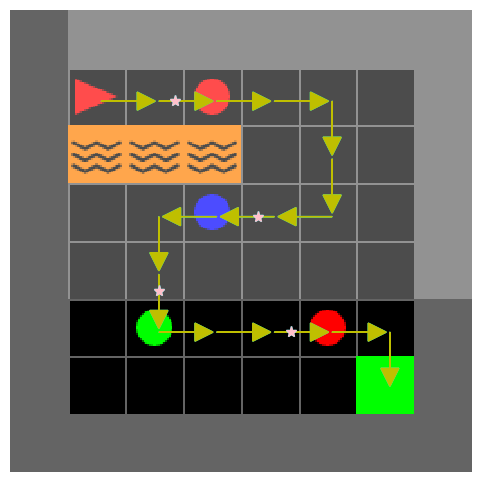

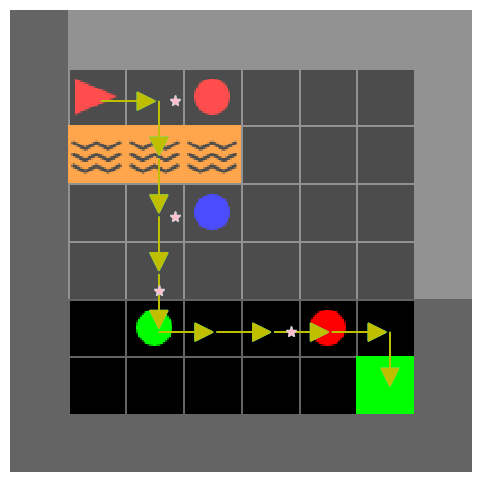

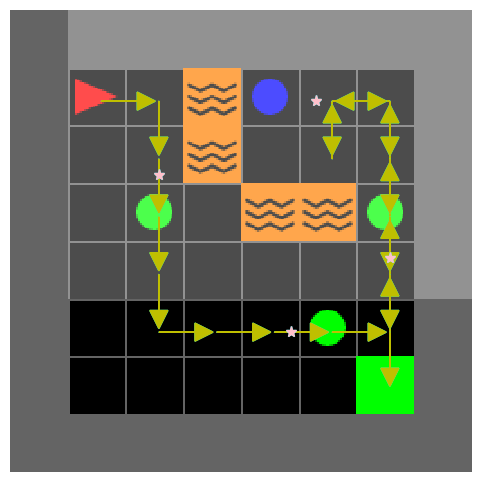

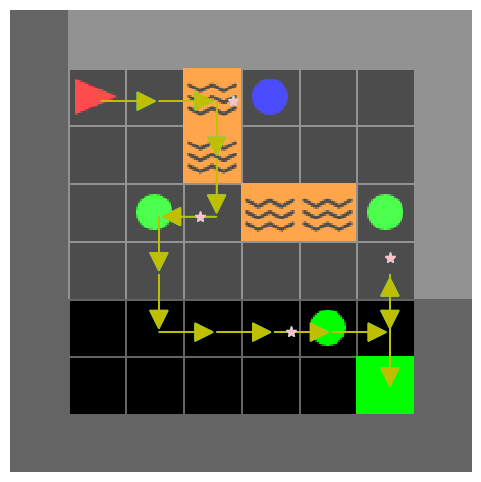

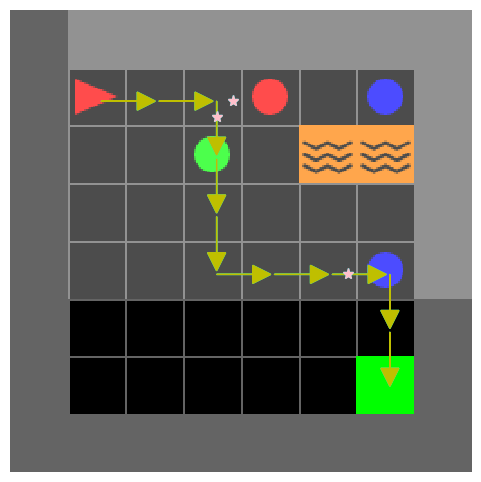

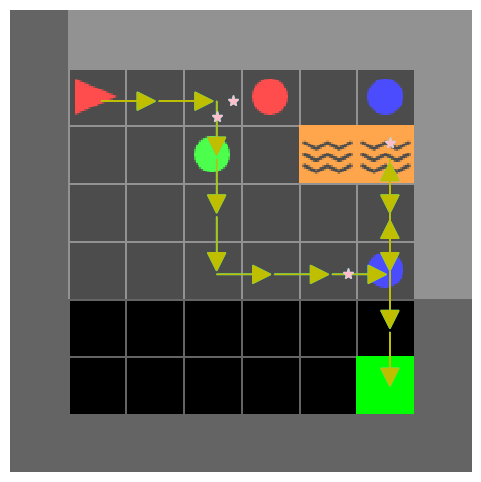

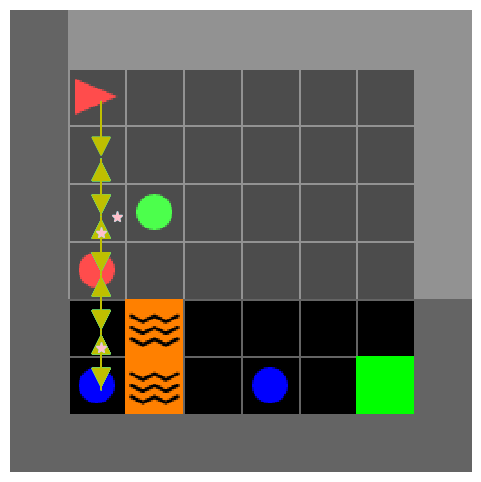

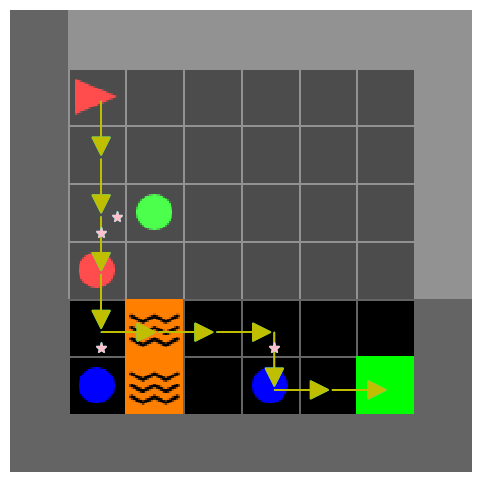

In [41]:
from dpu_clf import capture_agent_path, plot_all_move_sequence
import base64
from IPython.display import display, HTML

old_model_index = 1
change_to_model = 1

new_model_index = new_models_distance[old_model_index][change_to_model][0]
diff_env_index = new_models_distance[old_model_index][change_to_model][2]

base_env_name = "-1,3,4,-3,0.1Steps60Grid8_20250618"
env = create_env_from_model(base_env_name,
                grid_size=8,
                 agent_view_size=7,
                 max_steps=50,
                 highlight=True,
                 num_objects=5,
                 lava_cells=8,
                 train_env=False)

def path_to_image(path, env, unique_env):
    initial_k = {'unique_env': unique_env}
    current_obs = env.unwrapped.reset(**initial_k)
    copy_env = copy.deepcopy(env)

    agent = PPO.load(path)
    move_sequence, illigal_moves, total_reward, agent_actions = capture_agent_path(copy_env, agent)
    img = env.render()
    buf, _, _ = plot_all_move_sequence(img, move_sequence, agent_actions)
    return buf
for diff_env_index in range(1,19):
    print("unique_env", diff_env_index)
    buf1 = path_to_image(new_models_dict[new_model_index]['path'], env, diff_env_index)
    buf2 = path_to_image(new_models_dict[old_model_index]['path'], env, diff_env_index)
    print(f"\n{new_models_dict[old_model_index]['name']} path:",  get_episode_score(new_models_dict[old_model_index]['path'], env, diff_env_index))
    display(HTML(f'<img src="data:image/png;base64,{buf2}"/>'))

    print(f"{new_models_dict[new_model_index]['name']} path:",  get_episode_score(new_models_dict[new_model_index]['path'], env, diff_env_index))
    display(HTML(f'<img src="data:image/png;base64,{buf1}"/>'))







In [ ]:
# calculate the optional unique env for each model
base_env_name = "-1,3,4,-3,0.1Steps60Grid8_20250618"
env = create_env_from_model(base_env_name,
                grid_size=8,
                 agent_view_size=7,
                 max_steps=70,
                 highlight=True,
                 num_objects=5,
                 lava_cells=8,
                 train_env=False)   

for model in new_models_dict.values():
    agent = PPO.load(model['path'])
    optinal_unique_env = []
    for unique_env in range(1, 19):
        initial_k = {'unique_env': unique_env}
        current_obs = env.unwrapped.reset(**initial_k)
        current_obs = {'image': current_obs[0]['image']}
        
        done = False
        truncated = False
        score = 0
        while not (done or truncated):  # Limit to 50 steps per episode
            action, _ = agent.predict(current_obs, deterministic=True)
            current_obs, reward, done, truncated, _ = env.step(action)
            current_obs = {'image': current_obs['image']}
            score += reward
        if not truncated:
                optinal_unique_env += [unique_env]
    model['optinal_unique_env'] = optinal_unique_env
print(new_models_dict)

## Read From DataBase

In [ ]:
# List tables and show their contents using SQLAlchemy
# ...existing code...
from sqlalchemy import create_engine, inspect, text
from app import DATABASE_URI  # or use os.getenv("AZURE_DATABASE_URI", "sqlite:///test.db")

engine = create_engine(DATABASE_URI)
inspector = inspect(engine)

# List all tables
print("Tables in the database:")
for table_name in inspector.get_table_names():
    print(table_name)

# Show contents of each table (limit to 5 rows for brevity)
with engine.connect() as conn:
    for table_name in inspector.get_table_names():
        print(f"\nContents of table '{table_name}':")
        result = conn.execute(text(f"SELECT * FROM {table_name} LIMIT 15"))
        for row in result:
            print(row)

KeyboardInterrupt: 

## testing update env to action

<class 'numpy.ndarray'> (256, 256, 3)


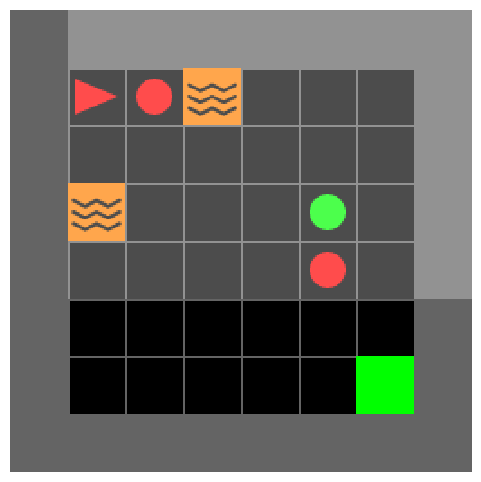

In [ ]:
highlight = True
step_cost = 0.02
num_objects = 5
lava_cells = 8
train_env = True
image_full_view = False
step_count = False

env =  CustomEnv(
            grid_size=grid_size,
            render_mode='rgb_array',
            max_steps=max_steps,
            highlight=highlight,
            step_cost=step_cost,
            num_objects=num_objects,
            lava_cells=lava_cells,
            train_env=train_env,
            image_full_view=image_full_view,
            agent_view_size=agent_view_size,
            color_rewards={'red':3, 'green': 1, 'blue': 0},
            step_count_observation=step_count,
        )

env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-3)

env.reset()
plot_state(env)



<class 'numpy.ndarray'> (256, 256, 3)


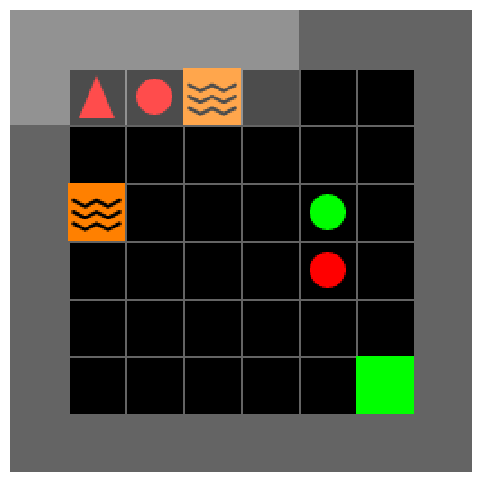

<class 'numpy.ndarray'> (256, 256, 3)


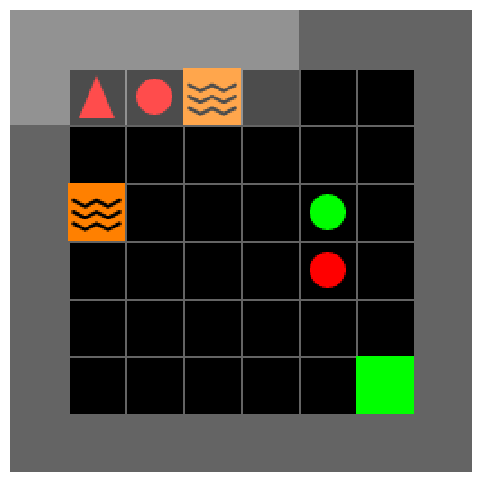

In [ ]:
tmp_env = copy.deepcopy(env)
actions = [Actions.forward, Actions.left, Actions.forward, Actions.forward]
for action in actions[:2]:
    obs, r, ter, tru, info = env.step(action)

def update_env_to_action(base_env, action_index, actions):
    tmp_env = copy.deepcopy(base_env)
    obs = tmp_env.get_wrapper_attr('current_state')
    for action in actions[:action_index]:
        obs, r, ter, tru, info = tmp_env.step(action)
    return tmp_env, obs

tmp_env, obs = update_env_to_action(tmp_env, 2, actions)

plot_state(tmp_env)
plot_state(env)

## Generated Results Graphs

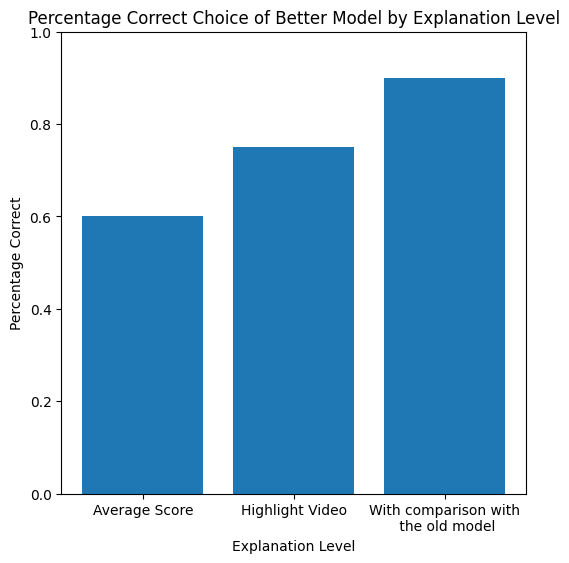

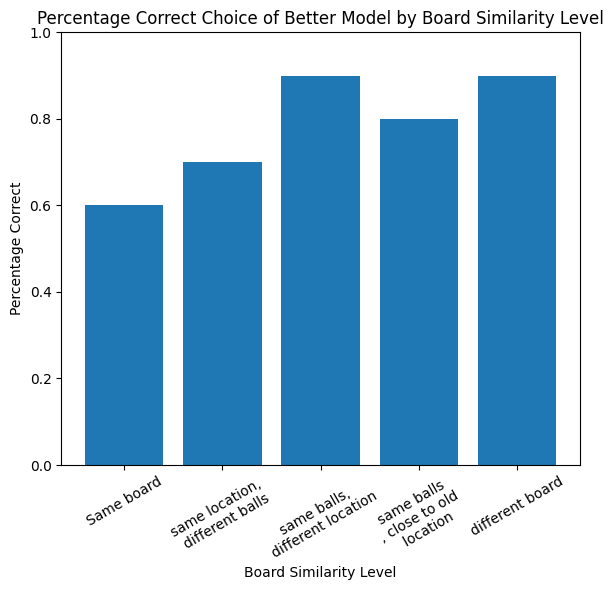

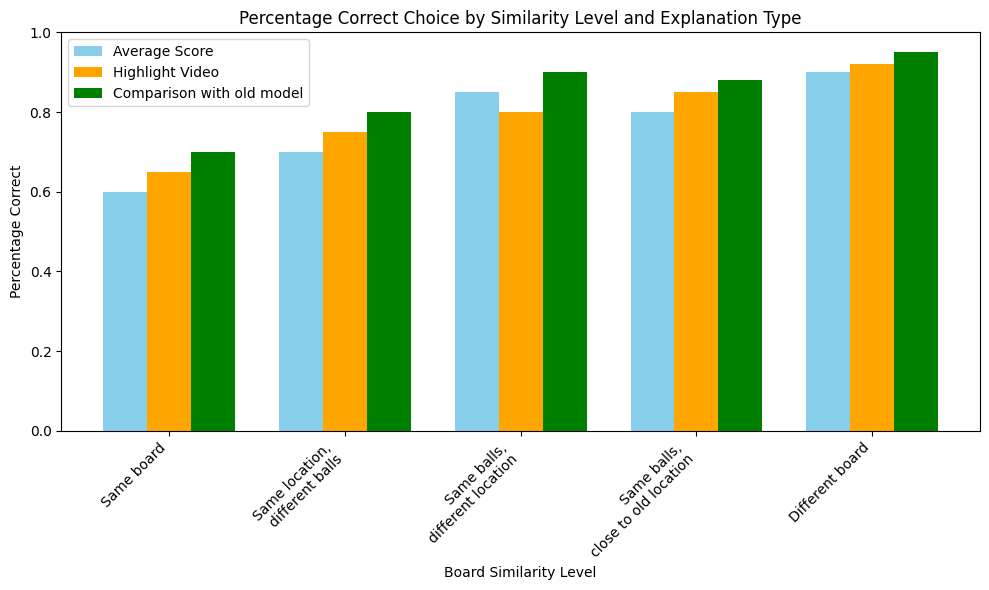

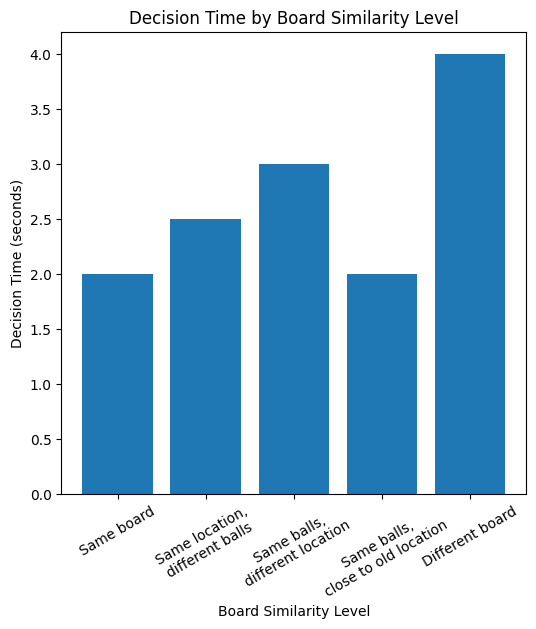

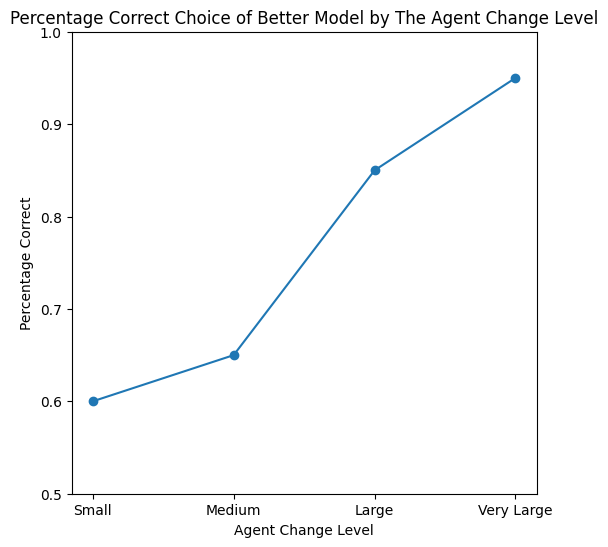

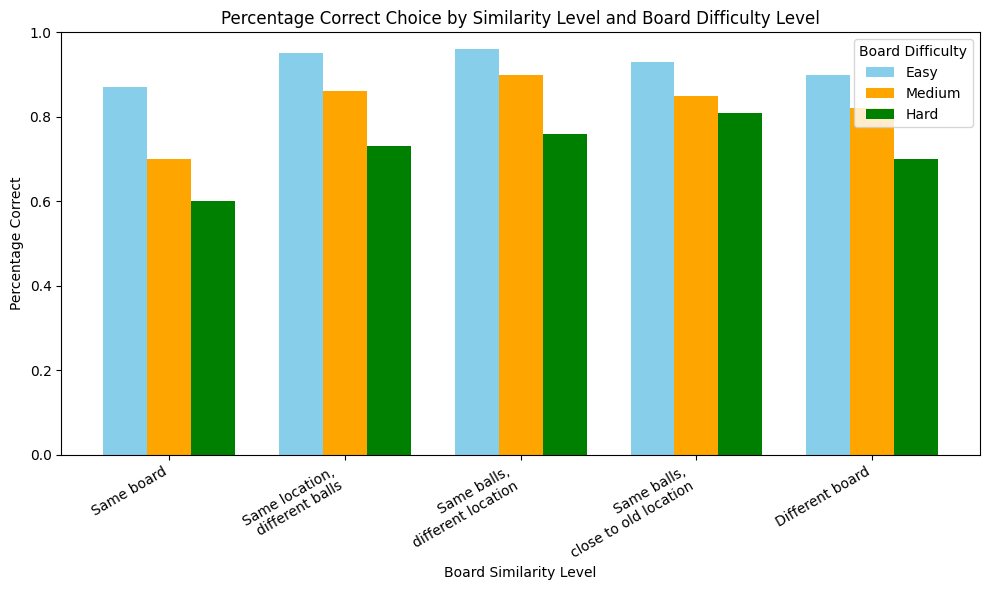

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Percentage correct choice by explanation level
explanations = ["Average Score", "Highlight Video", "With comparison with\n the old model"]
accuracy_exp = [0.60, 0.75, 0.9]

plt.figure()
plt.bar(explanations, accuracy_exp)
plt.title("Percentage Correct Choice of Better Model by Explanation Level")
plt.xlabel("Explanation Level")
plt.ylabel("Percentage Correct")
plt.ylim(0, 1)
plt.show()

# 2. Percentage correct choice by board similarity
similarity_levels = ["Same board", "same location, \ndifferent balls", "same balls, \ndifferent location", "same balls\n, close to old\n location", "different board"]
accuracy_sim = [0.60, 0.7, 0.90, 0.8, 0.9]

plt.figure()
plt.bar(similarity_levels, accuracy_sim)
plt.title("Percentage Correct Choice of Better Model by Board Similarity Level")
plt.xticks(rotation=30)
plt.xlabel("Board Similarity Level")
plt.ylabel("Percentage Correct")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()
import matplotlib.pyplot as plt
import numpy as np


# 3. Similarity levels and explanation types (adapt these as needed)
similarity_levels = ["Same board", "Same location,\ndifferent balls", "Same balls,\ndifferent location", "Same balls,\nclose to old location", "Different board"]
explanations = ["Average Score", "Highlight Video", "Comparison with old model"]

# Example data: rows = similarity levels, columns = explanation types
# Adjust these percentages with your actual data.
data = np.array([
    [0.60, 0.65, 0.70],
    [0.70, 0.75, 0.80],
    [0.85, 0.80, 0.90],
    [0.80, 0.85, 0.88],
    [0.90, 0.92, 0.95]
])

# Colors for each explanation type
colors = ["skyblue", "orange", "green"]

x = np.arange(len(similarity_levels))
bar_width = 0.25

plt.figure(figsize=(10,6))
for i in range(len(explanations)):
    plt.bar(x + i * bar_width, data[:, i], width=bar_width, color=colors[i], label=explanations[i])

plt.xticks(x + bar_width, similarity_levels, rotation=45, ha="right")
plt.xlabel("Board Similarity Level")
plt.ylabel("Percentage Correct")
plt.title("Percentage Correct Choice by Similarity Level and Explanation Type")
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()


# 4. Decision time by board similarity
decision_time = [2, 2.5, 3, 2, 4]  # seconds

plt.figure()
plt.bar(similarity_levels, decision_time)
plt.title("Decision Time by Board Similarity Level")
plt.xticks(rotation=30)
plt.xlabel("Board Similarity Level")
plt.ylabel("Decision Time (seconds)")
plt.show()

# 5. Percentage correct choice by feedback change magnitude
feedback_levels = ["Small", "Medium", "Large", "Very Large"]
accuracy_diff = [0.6, 0.65, 0.85, 0.95]

plt.figure()
plt.plot(feedback_levels, accuracy_diff, marker='o')
plt.title("Percentage Correct Choice of Better Model by The Agent Change Level")
plt.xlabel("Agent Change Level")
plt.ylabel("Percentage Correct")
plt.ylim(0.5, 1)
plt.show()



# 6. Percentage correct choice by explanation level on different boards levels
similarity_levels = ["Same board", "Same location,\ndifferent balls", "Same balls,\ndifferent location", "Same balls,\nclose to old location", "Different board"]
difficulty_levels = ["Easy", "Medium", "Hard"]

# Example data: rows = similarity levels, columns = difficulty levels
# Adjust these percentages with your actual data.
data = np.array([
    [0.87, 0.70, 0.60],
    [0.95, 0.86, 0.73],
    [0.96, 0.90, 0.76],
    [0.93, 0.85, 0.81],
    [0.90, 0.82, 0.70]
])

colors = ["skyblue", "orange", "green"]


x = np.arange(len(similarity_levels))
bar_width = 0.25

plt.figure(figsize=(10,6))
for i in range(len(difficulty_levels)):
    plt.bar(x + i * bar_width, data[:, i], width=bar_width, color=colors[i], label=difficulty_levels[i])

plt.xticks(x + bar_width, similarity_levels, rotation=30, ha="right")
plt.xlabel("Board Similarity Level")
plt.ylabel("Percentage Correct")
plt.title("Percentage Correct Choice by Similarity Level and Board Difficulty Level")
plt.ylim(0, 1)
plt.legend(title="Board Difficulty")
plt.tight_layout()
plt.show()



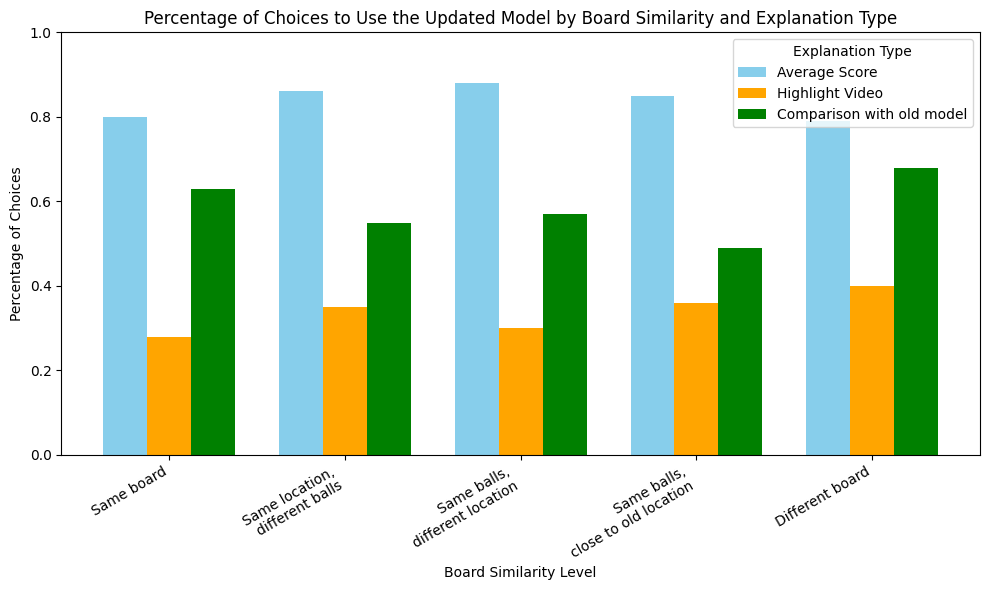

In [ ]:

# 7. The percentage of choices to use the updated model by board simillarity and explanation type
# Generate a bar plot for the percentage of choices to use the updated model
similarity_levels = ["Same board", "Same location,\ndifferent balls", "Same balls,\ndifferent location", "Same balls,\nclose to old location", "Different board"]
explanations = ["Average Score", "Highlight Video", "Comparison with old model"]

# Example data: rows = similarity levels, columns = explanation types
updated_model_data = np.array([
    [0.8, 0.28, 0.63],
    [0.86, 0.35, 0.55],
    [0.88, 0.3, 0.57],
    [0.85, 0.36, 0.49],
    [0.79, 0.4, 0.68]
])

# Colors for each explanation type
colors = ["skyblue", "orange", "green"]

x = np.arange(len(similarity_levels))
bar_width = 0.25

plt.figure(figsize=(10, 6))
for i in range(len(explanations)):
    plt.bar(x + i * bar_width, updated_model_data[:, i], width=bar_width, color=colors[i], label=explanations[i])

plt.xticks(x + bar_width, similarity_levels, rotation=30, ha="right")
plt.xlabel("Board Similarity Level")
plt.ylabel("Percentage of Choices")
plt.title("Percentage of Choices to Use the Updated Model by Board Similarity and Explanation Type")
plt.ylim(0, 1)
plt.legend(title="Explanation Type")
plt.tight_layout()
plt.show()



# 8. 



In [ ]:
# save in CSV preference vector and evaluation

name = 'LavaLaverNR_Grid8_20241113'
model_path = 'models\LavaLaverRedN8_20241113\iter_500000_steps' 
pref_vector = [-2,2,2,0,-0.1] # (red ball, green ball, blue ball, lava, step penalty)
evaluation = evaluate_agent(env, load_agent(env, model_path), num_episodes=100)
add_path_to_csv(name, model_path, pref_vector, evaluation)

load new model path models\LavaLaverRedN8_20241113\iter_500000_steps
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Observation space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
Environment Observation Space: Dict('image': Box(0, 255, (7, 7, 3), uint8))
PPO Model Observation Space: Dict('image': Box(0, 255, (3, 7, 7), uint8))
Function 'load_agent' took 0.0798 seconds.
place initial objects
simillarity level: 5
kwargs: {}
initial balls: [(5, 3, 'red', 3.0), (1, 6, 'blue', 3.0), (6, 3, 'green', 3.0), (6, 3, 'red', 3.0)]
lava cells: [(1, 3), (6, 3)]
place initial objects
simillarity level: 5
kwargs: {}
initial balls: [(2, 4, 'red', 3.0), (5, 6, 'red', 3.0), (2, 1, 'red', 3.0), (1, 6, 'green', 3.0)]
lava cells: [(1, 4), (6, 5)]
place initial objects
simillarity level: 5
kwargs: {}
initial balls: [(2, 2, 'green', 3.0), (2, 2, 'blue', 3.0), (4, 1, 'blue', 3.0), (3, 5, 'red', 3.0), (6, 3, 'green', 3.0)]
lava cells: [(3, 

dict_keys(['image', 'direction', 'mission'])
observation size: 7
dict_keys(['image'])


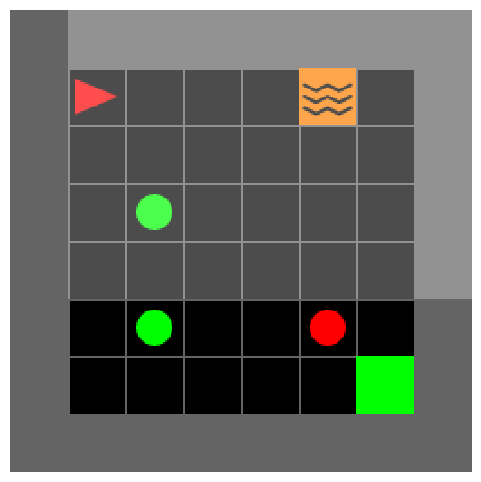

points {0: (1, 1, 0), 1: (2, 5, 2), 2: (2, 3, 2), 3: (2, 5, 2), 4: (5, 5, 2)}
Total reward: 6.0, Total steps: 10.0


c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.find_optimal_path to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.find_optimal_path` for environment variables or `env.get_wrapper_attr('find_optimal_path')` that will search the reminding wrappers.
  logger.warn(


In [ ]:
#test the environment

def plot_state(env):
    img = env.render()

    plt.imshow(img)
    plt.axis("off")
    plt.show()

env = CustomEnv(grid_size=8, render_mode='rgb_array', difficult_grid=False, max_steps=300, highlight=True, unique_env=0,
                        num_objects=5, lava_cells=2, train_env=True, image_full_view=False, agent_view_size=7, partial_obs=False)
state, _ = env.reset()
print(state.keys())
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-1.0)
# env = ImgObsWrapper(ObjObsWrapper(env))

state, _ = env.reset()
print(state.keys())
plot_state(env)


#test the environment
total_reward, total_steps = env.find_optimal_path()
print(f"Total reward: {total_reward}, Total steps: {total_steps}")
env.close()

In [ ]:

move_sequence, illigal_moves, total_reward, ligal_actions = capture_agent_path(env, agent)
buf, actions_with_location, buf_list = plot_all_move_sequence(img=env.render(), move_sequence=move_sequence, agent_true_actions=ligal_actions)

KeyError: 'direction'

In [ ]:
def load_agent(env, model_path):
    # policy_kwargs = dict(features_extractor_class=ObjEnvExtractor)
    custom_objects = {
        "policy_kwargs": {"features_extractor_class": ObjEnvExtractor},  # Example kernel size
        "clip_range": 0.2,  # Example custom parameters
        "lr_schedule": 0.001  # Example learning rate schedule
    }
    # Load the model
    ppo = PPO.load(f"models/{model_path}", custom_objects=custom_objects, env=env)
    return ppo

def is_illegal_move(action, last_obs, obs, agent_pos_befor, agent_pos):
    if action <= 1: # turn is always legal
        return False
    if action == 2 and agent_pos_befor == agent_pos:
        return True
    if action > 2 and np.array_equal(obs['image'], last_obs['image']):
        return True
    return False

# resert the environment and run the agent on that environment to find his path
def capture_agent_path(copy_env, agent):
    illigal_moves = 0
    last_obs = copy_env.unwrapped.current_state
    
    # last_obs = env.reset()
    # last_obs = last_obs[0]
    ligal_actions = []
    agent_actions = []
    state_record = [last_obs]
    total_reward = 0    
    done = False
    # copy_env = copy.deepcopy(env)
    # plt.imshow(copy_env.render())
    while not done:
        agent_pos_before = copy_env.unwrapped.agent_pos
        action, _states = agent.predict(last_obs, deterministic=True)
        agent_actions.append(action)
        obs, reward, done, _, info = copy_env.step(action)
        total_reward += reward
        
        if is_illegal_move(action, last_obs, obs, agent_pos_before, copy_env.agent_pos):
            illigal_moves += 1
            continue

        ligal_actions.append(action)
        last_obs = obs
        state_record.append(obs)
        # plt.imshow(copy_env.render())
        # plt.show()
        
        
    number_to_action = {0: 'turn right', 1: 'turn left', 3: 'pickup'}
    small_arrow = 'turn ' # small arrow is used to indicate the agent turning left or right
    agent_dir = "right"
    move_sequence = []
    for action in ligal_actions:
        if action == 0: # turn left
            agent_dir = turn_agent(agent_dir, "left")
            move_sequence.append(small_arrow + agent_dir)
        elif action == 1: # turn right
            agent_dir = turn_agent(agent_dir, "right")
            move_sequence.append(small_arrow + agent_dir)
        elif action == 2: # move forward
            move_sequence.append(agent_dir)
        elif action == 3: # pickup
            move_sequence.append('pickup ' +  agent_dir)
    return move_sequence, illigal_moves, total_reward, agent_actions


def turn_agent(agent_dir, turn_dir):
    turnning_dict = {("up", "left"): "left", ("up", "right"): "right", 
                     ("down", "left"): "right", ("down", "right"): "left",
                     ("left", "left"): "down", ("left", "right"): "up",
                     ("right", "left"): "up", ("right", "right"): "down"}
    return turnning_dict[(agent_dir, turn_dir)]

def plot_move_sequence(img, move_sequence, move_color='y', turn_color='orange', pickup_color='purple'):    
    start_point = (50, 50)
    arrow_size = 20
    arrow_head_size = 12
    small_shift = 9
    all_arrow_size = arrow_size + arrow_head_size
    move_arrow_sizes = {'up': (0, -20, 0, -all_arrow_size), 
                        'down': (0, 20, 0, all_arrow_size), 
                        'right': (20, 0, all_arrow_size, 0), 
                        'left': (-20, 0, -all_arrow_size, 0)}
    turn_arrow_sizes = {'turn up': (0, -5),
                        'turn down': (0, 5),
                        'turn right': (5, 0),
                        'turn left': (-5, 0)}
    pickup_direction = {'up': (0, -1),
                         'down': (0, 1),
                         'left': (-1, 0),
                         'right': (1, 0)}
    # arrows_list = ['right', 'right', 'down', 'down', 'down', 'down', 'down', 'right', 'right', 'up', 'right', 'down']

    fig, ax = plt.subplots()
    ax.imshow(img)
    current_point = start_point
    for action_name in move_sequence:
        if action_name in move_arrow_sizes.keys(): # a big arrow that represents a move
            ax.arrow(current_point[0], current_point[1], move_arrow_sizes[action_name][0], move_arrow_sizes[action_name][1], head_width=10, head_length=10, fc=move_color, ec=move_color)
            current_point = (current_point[0] + move_arrow_sizes[action_name][2], current_point[1] + move_arrow_sizes[action_name][3])
        else: # a small arrow that represents a turn or a pickup
            full_action = action_name.split(' ')
            action = full_action[0]
            pickup_position = pickup_direction[full_action[1]]
            
            if action == 'pickup':
                ax.plot(current_point[0] + small_shift * pickup_position[0], current_point[1] + small_shift*pickup_position[1], marker='*', markersize=10, color=pickup_color)
            else:
                ax.arrow(current_point[0], current_point[1], turn_arrow_sizes[action_name][0], turn_arrow_sizes[action_name][1], head_width=7, head_length=6, fc=turn_color, ec=turn_color)
            
            
    ax.axis('off')
    plt.show()

colors_reward = {'red': -2, 'green': 1, 'blue': 2}
env = CustomEnv(grid_size=8, render_mode='rgb_array', max_steps=2*10**2, agent_view_size=7, highlight=True, lava_cells=0, 
                partial_obs=False, colors_rewards=colors_reward)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-2.0)
model_path1 = "LavaHate8_20241112\iter_500000_steps"
model_path2 = "LavaLaver8_20241112\iter_500000_steps"

ppo1 = load_agent(env, "minigrid_custom_20240907/iter_90^5_steps")
ppo3 = load_agent(env, "orig_easy8_20241111\iter_1000000_steps")
ppo7 = load_agent(env, "LavaLaverRedN8_20241113\iter_500000_steps")
ppo5 = load_agent(env, model_path2)
ppo9 = load_agent(env, model_path1)
models = {"ppo1": ppo1, "ppo3": ppo3, "ppo5": ppo5,  "ppo7": ppo7,  "ppo9": ppo9}
colors_list = [
    "cyan", "magenta", "yellow", "white",
    "orange", "purple", "pink", "brown", "gray", "olive", "teal", "navy",
    "maroon", "lime", "indigo", "gold"]
colors_to_models = {"ppo1": "y", "ppo3": "w", "ppo5": "gold", "ppo7": "c", "ppo9": "gray"}


7
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [ ]:
def evaluate_agent(env, agent, num_episodes=100):
    total_reward = 0
    total_illegal_moves = 0
    for i in range(num_episodes):
        env.reset()
        move_sequence, illigal_moves, reward, agent_actions = capture_agent_path(env, agent)
        total_reward += reward
        total_illegal_moves += illigal_moves
    return total_reward / num_episodes, total_illegal_moves / num_episodes

for model_name, model in models.items():
    avg_reward, avg_illegal_moves, avg_moves = evaluate_agent(env, model, num_episodes=100)
    print(f"Model: {model_name}, Average reward: {avg_reward}, Average illegal moves: {avg_illegal_moves}")

c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.grid to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.grid` for environment variables or `env.get_wrapper_attr('grid')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.front_pos to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.front_pos` for environment variables or `env.get_wrapper_attr('front_pos')` that will search the reminding wrappers.
  logger.warn(
c:\Users\matan\anaconda3\envs\master_env\lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.actions to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.actions` for environment va

Model: ppo1, Average reward: 4.0252, Average illegal moves: 4.75
Model: ppo3, Average reward: 6.048430000000001, Average illegal moves: 0.2
Model: ppo5, Average reward: 5.1891400000000045, Average illegal moves: 0.74
Model: ppo7, Average reward: 8.971045000000004, Average illegal moves: 0.18
Model: ppo9, Average reward: 4.6684149999999995, Average illegal moves: 0.05


reset state:


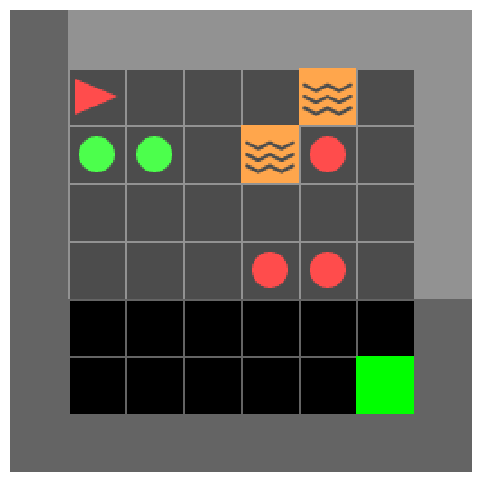

NameError: name 'models' is not defined

In [ ]:
env.reset()
img = env.render()
print("reset state:")
plot_state(env)
model_name = 'ppo1'
model = models[model_name]
# for model_name, model in models.items():
#     copy_env = copy.deepcopy(env)
#     # print("copy_env before:")
#     # plot_state(copy_env)
#     move_sequence, illigal_moves, total_reward, agent_action = capture_agent_path(copy_env, model)
#     # print("all actions: ", agent_action)
#     print("ligal actions: ", move_sequence)
#     print(f"model: {model_name}, illigal moves: {illigal_moves}, total reward: {total_reward}")

#     plot_move_sequence(img, move_sequence, move_color=colors_to_models[model_name])
#     # print("orig env after:")
#     # plot_state(env)
    


## Distance between 2 states

In [ ]:
WALL_SHIFT_FACTOR = 1
WALL_FACTOR = 10
DOOR_FACTOR = 0.1
BALLS_FACTOR = 3
min_ball_distance = 3

def manhattan_distance(p1, p2):
    return np.abs(p1[0] - p2[0]) + np.abs(p1[1] - p2[1])
    
def balls_distance(balls):
    ball_dist = 0
    for i in range(len(balls)-1):
        for j in range(i+1, len(balls)):
            ball_dist += np.linalg.norm(np.array(balls[i][:-1]) - np.array(balls[j][:-1]))
    return ball_dist

def balls_groups(balls_list):
    print(f"balls_list: {balls_list}")
    groups = []
    in_any_group = set()
    for i in range(len(balls_list)):
        if i in in_any_group:
            continue
        group = [balls_list[i]]
        need_to_check = [i]
        in_any_group.add(i)
        while need_to_check:
            ball_index = need_to_check.pop()
            check_ball = balls_list[ball_index]
            for j in range(len(balls_list)):
                if j in in_any_group: # TODO: option to switch to a list with all the balls that are not in any group
                    continue
                if manhattan_distance(check_ball, balls_list[j]) <= min_ball_distance:
                    group.append(balls_list[j])
                    in_any_group.add(j)
                    need_to_check.append(j)
        groups.append(group)
    print(f"groups: {groups}")
    
    res = []
    for group in groups:
        x_center = np.mean([ball[0] for ball in group])
        y_center = np.mean([ball[1] for ball in group])
        res.append((len(group), (x_center, y_center)))
    print(f"res: {res}")
    return res

def biggest_group(balls_groups):
    max = 0
    max_group = None
    for group in balls_groups:
        if group[0] > max:
            max = group[0]
            max_group = group
    return max_group
    
def state_distance(objects1, objects2):
    distance = 0
    if objects1['wall'][0] or objects2['wall'][0]: # if one of the states has a wall
        if objects1['wall'][0] != objects2['wall'][0]:
            distance += WALL_FACTOR
        else:
            distance += np.abs((objects1['wall'][2]) - (objects2['wall'][2]))*DOOR_FACTOR
            distance += np.abs((objects1['wall'][1]) - (objects2['wall'][1]))*WALL_SHIFT_FACTOR
    
    ball_groups1 = balls_groups(objects1['balls'])
    ball_groups2 = balls_groups(objects2['balls'])
    max_group1 = biggest_group(ball_groups1)
    max_group2 = biggest_group(ball_groups2)
    distance += np.abs(max_group1[0] - max_group2[0])*BALLS_FACTOR # changes in the biggest group size
    distance += np.abs(len([group for group in ball_groups1 if group[0] > 1]) - len([group for group in ball_groups2 if group[0] > 1]))# change in number of real groups(more then 1 ball)
    # distance += np.abs(balls_distance(objects1['balls']) - balls_distance(objects2['balls']))* BALLS_FACTOR
    return distance

In [ ]:
import numpy as np
# !pip install ipdb
import ipdb

def calculate_distance(state1, state2):
    """
    Calculate the Euclidean distance between two states represented by images.
    
    Parameters:
    state1 (np.ndarray): The first state image.
    state2 (np.ndarray): The second state image.
    
    Returns:
    float: The Euclidean distance between the two states.
    """
    # Flatten the images
    flat_state1 = state1.flatten()
    flat_state2 = state2.flatten()
    
    # Calculate the Euclidean distance
    distance = np.linalg.norm(flat_state1 - flat_state2)
    
    return distance

# Example usage
grid_size=10
env = CustomEnv(grid_size=grid_size, render_mode='rgb_array', difficult_grid=False, max_steps=100, highlight=True,
                num_objects=7, lava_cells=2, train_env=True, image_full_view=False, agent_view_size=grid_size*2-1)
env = NoDeath(ObjObsWrapper(env), no_death_types=('lava',), death_cost=-2.0)
state1, _ = env.reset()
state1 = state1['image']
plot_state(env)
objects1 = env.grid_objects()
state2, _ = env.reset()
objects2 = env.grid_objects()
# plot_state(env)
print(f"objects1: {objects1}")
# print(f"objects2: {objects2}")
distance = state_distance(objects1, objects2)
print(f"Distance between the two states: {distance}")

ModuleNotFoundError: No module named 'ipdb'

In [ ]:
def plot_state(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

### Manual Control

In [ ]:
from minigrid_custom_env import CustomEnv
# from base_env import SimpleEnv 
from minigrid.manual_control import ManualControl

env = CustomEnv(render_mode="human", difficult_grid=True, agent_pov=True)

# enable manual control for testing
manual_control = ManualControl(env, seed=42)
manual_control.start()

    


error: video system not initialized

## RL Control


### Train With PPO

In [ ]:
import minigrid
from minigrid.wrappers import ImgObsWrapper
from stable_baselines3 import PPO
from custom_env import *

from custom_env import SimpleEnv 
import os

models_dir = "models/PPO"
log_dir = "logs"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = FullyObsWrapper(env)

policy_kwargs = dict(
    features_extractor_class=MinigridFeaturesExtractor,
    features_extractor_kwargs=dict(features_dim=128),
)

env = SimpleEnv(render_mode="rgb_array", max_steps=10)
env = ImgObsWrapper(env)

model = PPO("CnnPolicy", env, policy_kwargs=policy_kwargs, verbose=1, tensorboard_log=log_dir)

TIMSTEMPS = 10000
for i in range(1, 15):
    model.learn(total_timesteps=TIMSTEMPS, reset_num_timesteps=False, tb_log_name="PPO")
    model.save(f"{models_dir}/model_{i}")
# model.learn(2e5)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.
Logging to logs\PPO_0
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 10       |
|    ep_rew_mean     | 32.5     |
| time/              |          |
|    fps             | 399      |
|    iterations      | 1        |
|    time_elapsed    | 5        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 10          |
|    ep_rew_mean          | 39.5        |
| time/                   |             |
|    fps                  | 266         |
|    iterations           | 2           |
|    time_elapsed         | 15          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.016745023 |
|    clip_fraction        | 0.259       |

#### load a model

In [ ]:
model_path = f"{models_dir}/model_13.zip"
load_model = PPO.load(model_path, env=env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


### Random Agent

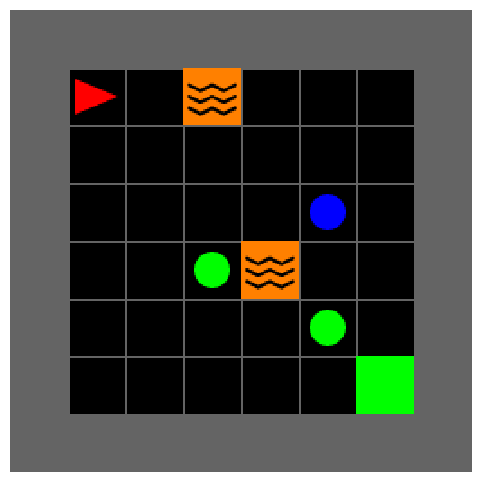

Action: 3,  Reward: -0.1, Done: False, Truncated: False, Info: {}


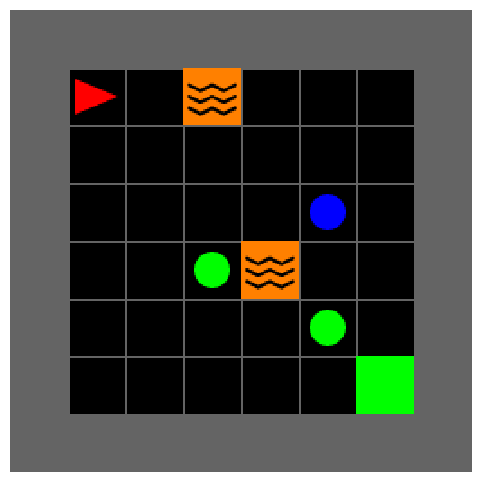

In [ ]:
def plot_state(env):
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    plt.show()

env = CustomEnv(render_mode="rgb_array", max_steps=10)
num_episodes = 2
for i in range(num_episodes):
# Reset the environment to get the initial state
    state, info = env.reset()
    # plot_state(env)
    score = 0
    # Run the simulation
    done = False
    plot_state(env)
    while not done:
        # Sample a random action from the action space
        action = env.action_space.sample()

        # Take the action in the environment
        state, reward, done, truncated, info = env.step(action)
        score += reward
        if reward != 0:
            print(f"Action: {action},  Reward: {reward}, Done: {done}, Truncated: {truncated}, Info: {info}")
            plot_state(env)

    plot_state(env)
    print(f"episode {i}: score: {score}")

env.close()


In [ ]:
from app_db import *
from datetime import datetime

with app.app_context():
    db.create_all()
    players = Player.query.all()

    print(players)

[Player(1, 1)]
